# CEIA – Análisis de Series de Tiempo I | TP2: Linear Predictive Coding (LPC)

Notebook del TP2 de la materia **Análisis de Series de Tiempo I** de la Carrera de Especialización en Inteligencia Artificial (CEIA – UBA).

---

**Alumno**

- **Emiliano Iparraguirre** (<emiliano.iparraguirre22@gmail.com>)  
---
**Objetivo.**

- Implementar el flujo de trabajo del TP de LPC sobre el audio `estocastico.wav`: carga y escucha del audio, marcado de segmentos (vocales), y preparación para estimar LPC por ventana.
---
**Datos y utilidades.**
- Audio: `data/estocastico.wav` en tu Google Drive.
- Utilidad interactiva para recortar segmentos: `recorte.py` (función `recortar`).

---

## Ejercicio 1 Utilizando load (librosa), cargar el archivo de audio estocastico. wav y escucharlo utilizando Audio (IPython.display).

Vamos a:
1. Montar Google Drive.
2. Apuntar a la carpeta `data` donde está `estocastico.wav`.
3. Cargar el audio con `librosa.load` y escucharlo con `IPython.display.Audio`.

In [1]:
# --- Montar Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# --- Rutas ---
AUDIO_PATH = '/content/drive/MyDrive/Colab Notebooks/CEIA 2025/11_AST1/TP2/data/estocastico.wav'

# --- Carga y escucha ---
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np

y, fs = librosa.load(AUDIO_PATH)
print(f'Fs = {fs} Hz, muestras = {len(y)}, duración ≈ {len(y)/fs:.2f} s')

# Audio embebido
ipd.Audio(y, rate=fs)


Fs = 22050 Hz, muestras = 44100, duración ≈ 2.00 s


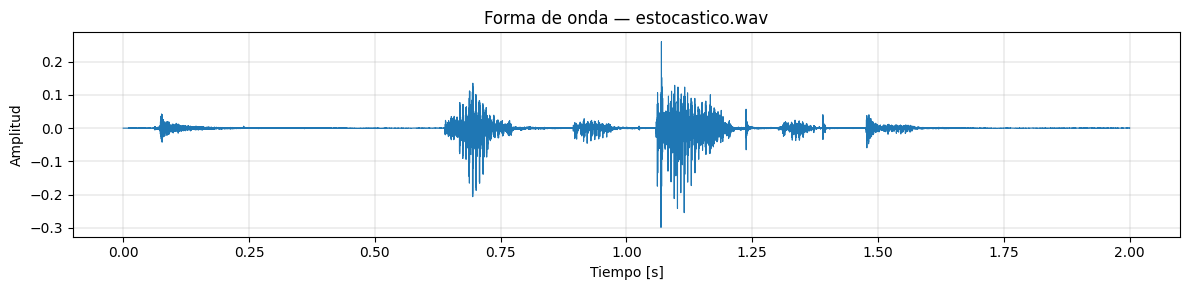

In [3]:
# Forma de onda en función del tiempo (segundos)
t = np.arange(len(y)) / fs
plt.figure(figsize=(12, 3))
plt.plot(t, y, linewidth=0.8)
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.title('Forma de onda — estocastico.wav')
plt.grid(True, linewidth=0.3)
plt.tight_layout()
plt.show()

## Ejercicio 2 Determinar aproximadamente los instantes de tiempo donde se pronuncian las vocales en el audio estocastico. wav . La función recortar de recorte. py puede ser útil.

Vamos a:
1. Visualizar la forma de onda para ubicar regiones de interés (vocales).
2. Para **determinar aproximadamente** los instantes donde se pronuncian las vocales, usamos la herramienta interactiva `recortar` (dos deslizadores que fijan *inicio* y *fin*, botón para **reproducir** el segmento y botón para **guardar** el marcador).

In [4]:
# En Colab, aseguremos soporte de widgets (suele venir activo)
from google.colab import output
output.enable_custom_widget_manager()

# Importar la utilidad recortar
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/CEIA 2025/11_AST1/TP2/data')

from recorte import recortar  # ← provisto por la cátedra

# Interfaz interactiva para marcar segmentos (devuelve lista de (inicio, fin) en muestras)
markers = recortar(y, fs)


FloatSlider(value=5000.0, description='Inicio:', max=39100.0, min=5000.0, step=100.0)

FloatSlider(value=6000.0, description='Fin:', max=39100.0, min=5000.0, step=100.0)

Button(description='Reproducir segmento', style=ButtonStyle())

Button(description='Agregar marcador', style=ButtonStyle())

Output()

In [5]:
# Últimos markers generados (comentar si se generan nuevos markers)
markers = [
    (15300.0, 15900.000000000002),
    (21100.0, 21700.0),
    (24900.0, 25500.000000000004),
    (29300.0, 29900.000000000004),
    (33400.0, 34000.0)
]

In [6]:
# Guardar "markers" en un .json
import json
import os

# Crear la carpeta "data" si no existe
os.makedirs("/content/drive/MyDrive/Colab Notebooks/CEIA 2025/11_AST1/TP2/data", exist_ok=True)

# Guardar markers en un archivo JSON
with open("/content/drive/MyDrive/Colab Notebooks/CEIA 2025/11_AST1/TP2/data/markers.json", "w") as f:
    json.dump(markers, f)

In [7]:
# Abrir último "markers" guardado (descomentar si se quiere recuperar)
#with open("/content/drive/MyDrive/Colab Notebooks/CEIA 2025/11_AST1/TP2/data/markers.json", "r") as f:
#    markers = json.load(f)

In [8]:
# Al finalizar, la lista "markers" tengo pares (inicio, fin) seleccionados.
markers

[(15300.0, 15900.000000000002),
 (21100.0, 21700.0),
 (24900.0, 25500.000000000004),
 (29300.0, 29900.000000000004),
 (33400.0, 34000.0)]

A partir de aquí, una vez guardados los segmentos de vocales en `markers`,
continuaremos con el flujo de LPC por ventanas, calculando autocorrelaciones sesgadas, tal como se describe en el TP.

## Ejercicio 3 Utilizando correlate (numpy) implementar una función que calcule los coeficientes LPC de una señal (representativa de un solo sonido) para N > M.

### Función `lpc_acf(x, M)` — Cálculo de coeficientes LPC por autocorrelación (Yule–Walker)

**Objetivo.** Estimar los coeficientes LPC de un **segmento corto** que representa **una sola vocal**, usando la **autocorrelación** calculada con `numpy.correlate`. Se asume \(N > M\) (longitud del segmento mayor que el orden del modelo).

**Modelo adoptado (AR/LPC):**

$$
x[n] + \sum_{k=1}^{M} a_k\,x[n-k] = e[n]
\quad\Longleftrightarrow\quad
A(z) = 1 + a_1 z^{-1} + \cdots + a_M z^{-M}.
$$

---

**Pasos del método (autocorrelación / Yule–Walker):**

1. **Centrado del segmento:**

   $$
   \tilde{x}[n] = x[n] - \bar{x}.
   $$

2. **Autocorrelación** con `np.correlate` (modo `full`) y se toman los lags  
   \( r[0], r[1], \dots, r[M] \).

   - Opción *biased*: dividir por \(N\) para que \(R\) sea bien condicionada.

3. **Matriz de Toeplitz:**

   $$
   R_{ij} = r[|i-j|], \quad \text{dimensión } M \times M.
   $$

4. **Ecuaciones de Yule–Walker:**

   $$
   R \, \mathbf{a} = - \mathbf{r}_{1:M},
   $$

   donde

   $$
   \mathbf{r}_{1:M} = \begin{bmatrix} r[1] \\ r[2] \\ \vdots \\ r[M] \end{bmatrix}.
   $$

   Se resuelve para

   $$
   \mathbf{a} = \begin{bmatrix} a_1 \\ a_2 \\ \vdots \\ a_M \end{bmatrix}.
   $$

5. **Varianza del error:**

   $$
   \sigma_e^2 = r[0] + \sum_{k=1}^M a_k \, r[k].
   $$

---

**Entradas.**
- `x` : array 1D con el segmento (una vocal).
- `M` : orden del modelo LPC.
- `biased` : si `True`, autocorrelación sesgada (divide por \(N\)).

**Salidas.**
- `a_poly` : polinomio \(A(z)=[1, a_1,\ldots,a_M]\).
- `a` : coeficientes \([a_1,\ldots,a_M]\).
- `err_var` : varianza del error de predicción \(\sigma_e^2\).
- `r` : autocorrelación usada \([r[0],\ldots,r[M]]\).

**Observación:** este es el **método clásico de autocorrelación**. Para señales de voz, suele preferirse la versión sesgada para que \(R\) sea definida positiva y la solución sea estable.

In [9]:
# -- Función LPC por autocorrelación (usando numpy.correlate) --
import numpy as np

def lpc_acf(x, M, biased=True):
    """
    Coeficientes LPC por método de autocorrelación (Yule–Walker),
    calculando r[k] con numpy.correlate. Requiere N > M.

    Modelo AR/LPC adoptado:
        x[n] + sum_{k=1}^M a_k x[n-k] = e[n]
    => Polinomio del filtro de predicción: A(z) = 1 + a1 z^-1 + ... + aM z^-M

    Parámetros
    ----------
    x : array_like
        Señal (segmento monofónico, una vocal). Se centrará (quita media).
    M : int
        Orden LPC (número de coeficientes a_k).
    biased : bool
        Si True, usa autocorrelación sesgada (divide por N); si False, no divide.

    Devuelve
    --------
    a_poly : ndarray shape (M+1,)
        Coeficientes del polinomio A(z) con a_poly[0] = 1.
    a : ndarray shape (M,)
        Coeficientes a_k (sin el 1 inicial).
    err_var : float
        Varianza del error de predicción: σ_e^2 = r[0] + sum_{k=1}^M a_k r[k].
    r : ndarray shape (M+1,)
        Autocorrelación r[0..M] usada.

    Notas
    -----
    Ecuaciones de Yule–Walker (método de autocorrelación):
        R a = -r_vec,  con R_{ij} = r[|i-j|],  r_vec = [r[1],...,r[M]]^T
        a = - R^{-1} r_vec
    """
    x = np.asarray(x, dtype=float)
    N = len(x)
    if N <= M:
        raise ValueError(f"Se requiere N>M. Recibido N={N}, M={M}.")

    # centrar (recomendado para LPC)
    x = x - np.mean(x)

    # autocorrelación con np.correlate (full), tomar lags 0..M
    r_full = np.correlate(x, x, mode='full')            # tamaño 2N-1
    mid = N - 1
    r = r_full[mid:mid+M+1].copy()                      # r[0..M]
    if biased:
        r /= N

    # armar matriz de Toeplitz R (M x M) y vector r_vec (M,)
    R = np.empty((M, M), dtype=float)
    for i in range(M):
        for j in range(M):
            R[i, j] = r[abs(i - j)]
    r_vec = r[1:M+1]

    # resolver R a = -r_vec
    a = -np.linalg.solve(R, r_vec)

    # varianza del error de predicción
    err_var = float(r[0] + np.dot(r[1:M+1], a))

    # polinomio A(z) = [1, a1, ..., aM]
    a_poly = np.concatenate(([1.0], a))
    return a_poly, a, err_var, r

In [10]:
# -- Ejemplo con los markers de "estocástico" --
M = 10  # orden LPC de ejemplo (ajustá según lo que pidan)

lpc_resultados = []
for i, (ini, fin) in enumerate(markers, start=1):
    seg = y[int(ini):int(fin)]
    a_poly, a, err_var, r = lpc_acf(seg, M=M, biased=True)
    lpc_resultados.append((i, len(seg), a_poly, err_var))
    print(f"Vocal {i}: N={len(seg)}, σ_e^2={err_var:.4e}")
    print("A(z) =", a_poly, "\n")

Vocal 1: N=600, σ_e^2=1.1898e-04
A(z) = [ 1.         -1.72571945  1.21882525 -0.45170245  0.23555649 -0.01096854
 -0.1141852  -0.20122923  0.2507672  -0.17175298  0.04978925] 

Vocal 2: N=600, σ_e^2=8.7004e-07
A(z) = [ 1.         -1.65848158  0.88991668 -0.23528404  0.06705066 -0.06123145
  0.16525138 -0.23636984  0.08595356  0.1692948  -0.08002979] 

Vocal 3: N=600, σ_e^2=9.7663e-05
A(z) = [ 1.         -1.75078028  1.45778778 -0.60737395 -0.20048454  0.61105932
 -0.22403301 -0.29046195  0.40469975 -0.19990981  0.0636687 ] 

Vocal 4: N=600, σ_e^2=7.3000e-06
A(z) = [ 1.         -1.21343577  0.47021391 -0.28632519  0.23413607  0.10276089
 -0.00614528 -0.3388027  -0.07965809  0.03009734  0.13531438] 

Vocal 5: N=600, σ_e^2=2.2836e-06
A(z) = [ 1.         -1.01854472  0.37034366 -0.36859109  0.02705256 -0.25617335
  0.35606764 -0.40862287  0.56057161 -0.20120734  0.07774645] 



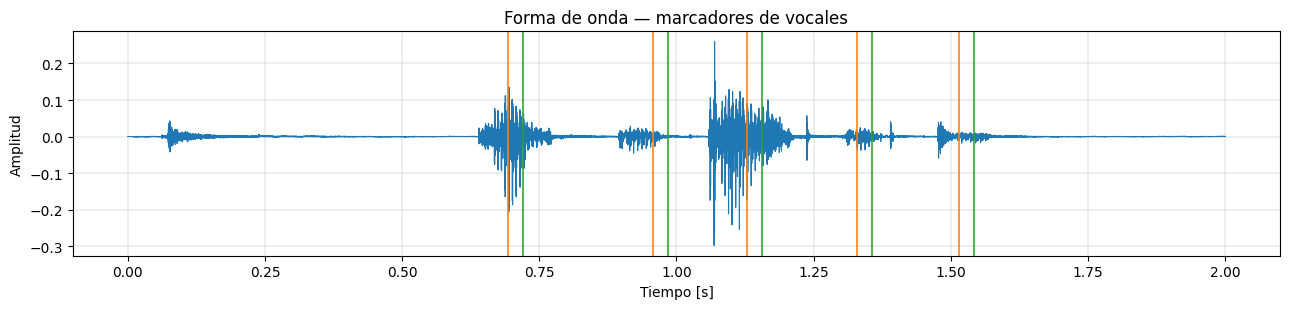

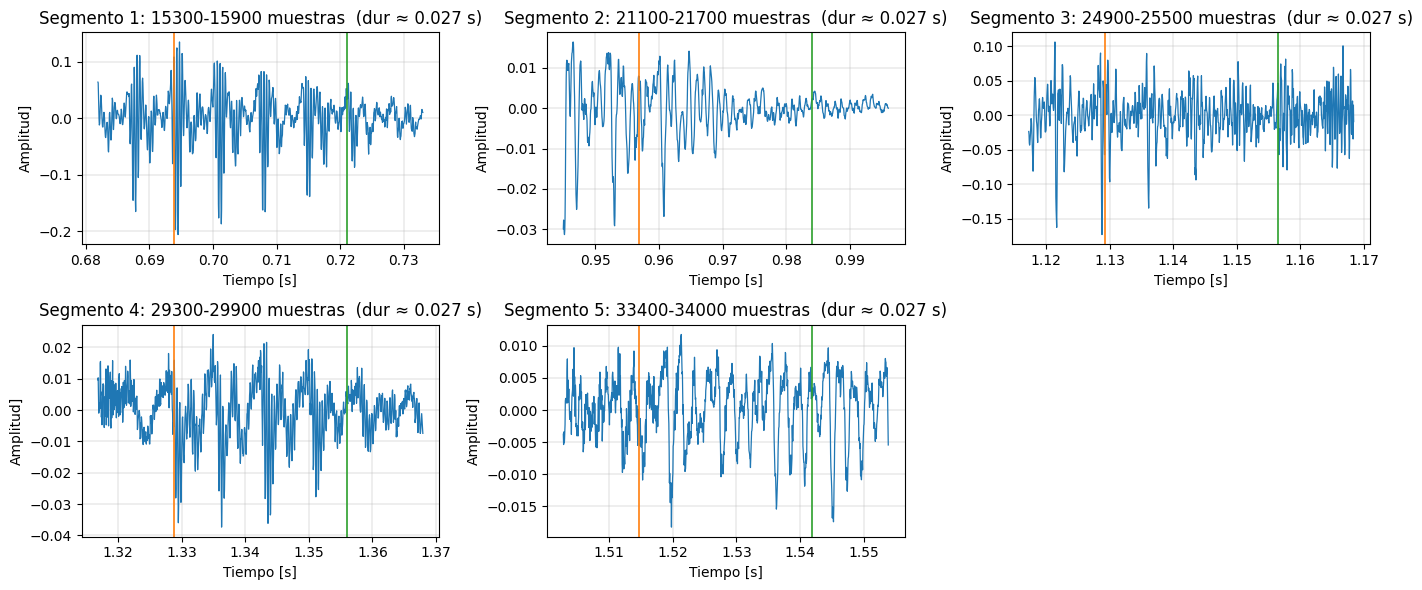

In [11]:
# Graficamos los segmentos para verificar

def plot_wave_with_segments(y, fs, markers, expand_ms=10):
    """
    Grafica la forma de onda completa y marca cada segmento (inicio/fin).
    Luego, hace subplots con zoom para cada segmento (con margen expand_ms).
    """
    t = np.arange(len(y)) / fs

    # --- Vista global ---
    plt.figure(figsize=(13, 3.2))
    plt.plot(t, y, linewidth=0.8)
    for (s, e) in markers:
        plt.axvline(s/fs, color='C1', linewidth=1.5, alpha=0.8)
        plt.axvline(e/fs, color='C2', linewidth=1.5, alpha=0.8)
    plt.title('Forma de onda — marcadores de vocales')
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Amplitud')
    plt.grid(True, linewidth=0.3)
    plt.tight_layout()
    plt.show()

    # --- Zoom por segmento ---
    nseg = len(markers)
    ncols = min(3, nseg)
    nrows = int(np.ceil(nseg / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(14, 3.0*nrows), squeeze=False)
    axes = axes.ravel()

    expand = int(expand_ms * 1e-3 * fs)  # margen en muestras
    for i, (s, e) in enumerate(markers):
        s = int(s); e = int(e)
        s0 = max(0, s - expand)
        e0 = min(len(y), e + expand)

        ti = np.arange(s0, e0) / fs
        axes[i].plot(ti, y[s0:e0], linewidth=0.9)
        axes[i].axvline(s/fs, color='C1', linewidth=1.2)
        axes[i].axvline(e/fs, color='C2', linewidth=1.2)
        axes[i].set_title(f'Segmento {i+1}: {s}-{e} muestras  (dur ≈ {(e-s)/fs:.3f} s)')
        axes[i].set_xlabel('Tiempo [s]')
        axes[i].set_ylabel('Amplitud]')
        axes[i].grid(True, linewidth=0.3)

    # ocultar ejes sobrantes si los hay
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Llamada
plot_wave_with_segments(y, fs, markers, expand_ms=12)

## Ejercicio 4 — Respuesta impulsiva del **predictor LPC** (derivación analítica)

**Enunciado.** Dados los coeficientes LPC (orden \(M\)) de un segmento de voz, hallar **analíticamente** la respuesta impulsiva \(h_f[t]\) de un sistema LTI tal que, con entrada \(y[t]\) (la señal del segmento), la salida sea la **predicción lineal** $\hat{x}[t]$:

$$
\hat{x}[t] \;=\; (y * h_f)[t].
$$

---

### 1) Modelo LPC (AR) adoptado
El modelo AR/LPC de orden \(M\) se escribe como:

$$
x[n] + \sum_{k=1}^{M} a_k\, x[n-k] \;=\; e[n],
$$

donde \(e[n]\) es el **error (residuo) de predicción** y $\{a_k\}$ son los coeficientes LPC.

La **predicción lineal a un paso** es:

$$
\hat{x}[n] \;=\; -\sum_{k=1}^{M} a_k\, x[n-k].
$$

---

### 2) Expresar la predicción como convolución
Queremos un sistema LTI con respuesta impulsiva \(h_f[n]\) tal que:

$$
\hat{x}[n] \;=\; (y*h_f)[n] \;=\; \sum_{m=-\infty}^{\infty} y[m]\,h_f[n-m]
\;=\; \sum_{k=-\infty}^{\infty} y[n-k]\,h_f[k].
$$

Comparando con la forma de la predicción:

$$
\hat{x}[n] \;=\; -\sum_{k=1}^{M} a_k\, y[n-k],
$$

se concluye que basta elegir un **FIR causal** de orden \(M\) con coeficientes:

$$
h_f[0]=0, \qquad
h_f[k] = -a_k \quad \text{para } k=1,\dots,M, \qquad
h_f[k]=0 \ \ \text{si } k\notin\{0,1,\dots,M\}.
$$

**Por lo tanto:**

$$
h_f[n] \;=\; -\sum_{k=1}^{M} a_k\, \delta[n-k],
$$

y en dominio-\(z\):

$$
H_f(z) \;=\; \mathcal{Z}\{h_f[n]\} \;=\; -\sum_{k=1}^{M} a_k\, z^{-k}.
$$

---

### 3) Verificación rápida
Con esa \(h_f\):

$$
(y*h_f)[n] \;=\; \sum_{k=1}^{M} (-a_k)\,y[n-k]
\;=\; -\sum_{k=1}^{M} a_k\, x[n-k]
\;=\; \hat{x}[n],
$$

como se quería.

---

### 4) Relación con filtros de **análisis** y **síntesis** LPC
Define el **filtro de análisis** (blanqueo):

$$
A(z) \;=\; 1 + \sum_{k=1}^{M} a_k\, z^{-k}.
$$

Entonces:

$$
e[n] \;=\; A(z)\,x[n],
\qquad
\hat{x}[n] \;=\; x[n] - e[n].
$$

Reescribiendo:

$$
\hat{x}[n] \;=\; \big(1 - A(z)\big)\,x[n]
\;=\; \underbrace{-\sum_{k=1}^{M} a_k z^{-k}}_{H_f(z)}\,x[n].
$$

Esto confirma que el **predictor** es un FIR con función de transferencia:

$$
H_f(z) \;=\; -\sum_{k=1}^{M} a_k z^{-k}.
$$

---

### 5) Conclusión
La respuesta impulsiva del sistema LTI que genera la **predicción LPC** $\hat{x}[t]$ a partir de la señal \(y[t]\) es:

$$
h_f[t] = -\sum_{k=1}^{M} a_k\, \delta[t-k],
$$

un **FIR causal** de orden \(M\) cuyos coeficientes son los LPC con signo cambiado y sin término en \(t=0\).

## Ejercicio 5 — Estimación de la frecuencia de excitación usando `convolve`

**Idea**  
Conocidos los coeficientes LPC $\{a_k\}_{k=1}^M$, el **predictor LPC** del Ejercicio 4 tiene respuesta impulsiva:

$$
h_f[n] = -\sum_{k=1}^M a_k \, \delta[n-k]
$$

y el **filtro de análisis** (o blanqueo) es:

$$
A(z) = 1 + \sum_{k=1}^M a_k z^{-k}
$$

Aplicando $A(z)$ a la señal $y[n]$, obtenemos el **residuo de predicción**:

$$
e[n] = (y * a_{\text{poly}})[n], \quad a_{\text{poly}} = [1, a_1, \ldots, a_M]
$$

Como \(e[n]\) aproxima la **excitación glotal**, su autocorrelación presenta un **pico en el período de pitch** (para voz sonora).  
Entonces la frecuencia fundamental se estima como:

$$
\hat{f}_0 = \frac{f_s}{\arg \max_{\ell \in \mathcal{L}} \, \mathrm{ACF}_e[\ell]}
$$

restringiendo $\mathcal{L}$ al rango plausible de períodos (ejemplo: 80–350 Hz).

In [12]:
# -------------------------------
# Ejercicio 5: estimar f0 (pitch) desde LPC usando CONVOLVE
# -------------------------------

def estimate_pitch_from_lpc(y, a_poly, fs, fmin=80.0, fmax=350.0):
    """
    Estima la frecuencia de excitación (f0) a partir de la señal y[n]
    y los coeficientes LPC (polinomio a_poly = [1, a1, ..., aM]).
    1) Residuo e[n] = (y * a_poly)[n]   (convolve -> "same")
    2) ACF del residuo y búsqueda de pico en el rango [fs/fmax, fs/fmin]

    Parámetros
    ----------
    y : array_like
        Señal (segmento de una vocal). Mejor si viene centrada; aquí se centra.
    a_poly : array_like (M+1,)
        Polinomio de análisis LPC: [1, a1, ..., aM].
    fs : float
        Frecuencia de muestreo (Hz).
    fmin, fmax : float
        Rango plausible de f0 (Hz).

    Devuelve
    --------
    f0_hat : float or None
        Estimación de la frecuencia fundamental (Hz). None si no se encuentra pico válido.
    lag_peak : int or None
        Lag del pico usado (muestras).
    e : ndarray
        Residuo de predicción.
    acf : ndarray
        Autocorrelación no normalizada del residuo (lags >= 0).
    """
    y = np.asarray(y, dtype=float)
    y = y - np.mean(y)

    # Residuo de predicción (convolve como filtrado FIR con A(z))
    e = np.convolve(y, a_poly, mode="same")

    # ACF del residuo (usamos correlate "full" y nos quedamos con lags no negativos)
    acf_full = np.correlate(e, e, mode="full")
    mid = len(acf_full) // 2
    acf = acf_full[mid:]  # lags 0..N-1

    # Rango de lags asociado al rango de f0
    lag_min = max(1, int(np.floor(fs / fmax)))
    lag_max = min(len(acf) - 1, int(np.ceil(fs / fmin)))
    if lag_max <= lag_min:
        return None, None, e, acf

    # Buscamos el pico en ese rango (ignoramos lag 0)
    roi = acf[lag_min:lag_max + 1]
    if roi.size == 0 or np.all(roi <= 0):
        return None, None, e, acf

    k_rel = int(np.argmax(roi))
    lag_peak = lag_min + k_rel
    f0_hat = fs / lag_peak if lag_peak > 0 else None

    return f0_hat, lag_peak, e, acf

### Ejemplo de prueba de la función `estimate_pitch_from_lpc`

Vamos a probar la función implementada para estimar la frecuencia fundamental `f0` de un segmento de la señal.  
Pasos:
1. Seleccionar un segmento de la señal de audio (por ejemplo, la primera vocal recortada con `markers`).  
2. Calcular los coeficientes LPC con el orden `M` elegido.  
3. Llamar a la función `estimate_pitch_from_lpc` y graficar:
   - La señal del residuo `e[n]`.  
   - Su autocorrelación (ACF).  
   - Indicar visualmente el pico que corresponde al período de pitch.

Frecuencia fundamental estimada: 103.90 Hz (lag = 154)


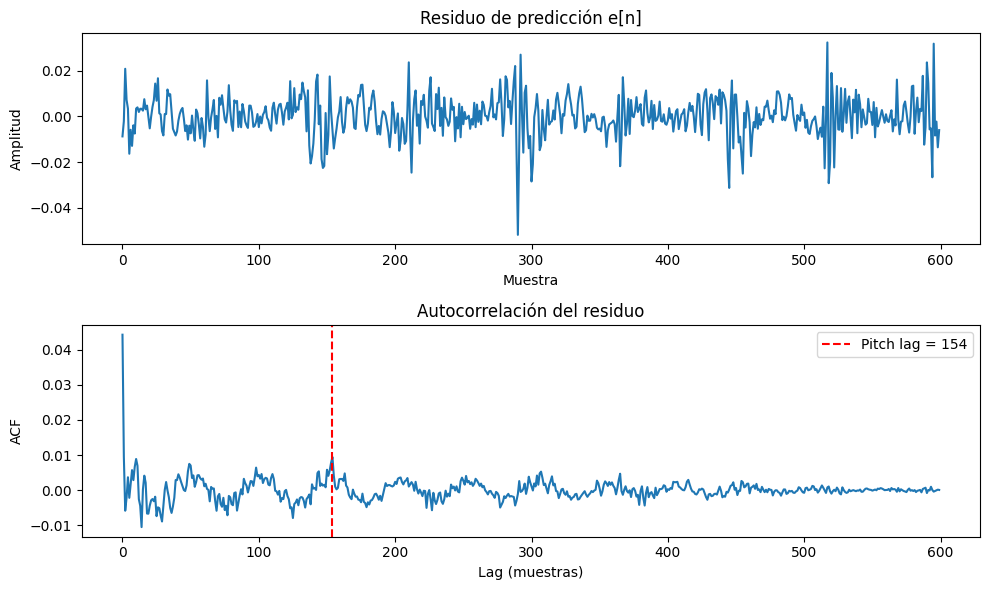

In [13]:
# Ejemplo

# --- Parámetros de prueba ---
M = 12  # orden del modelo LPC
fs = 16000  # frecuencia de muestreo del audio cargado

# Seleccionamos un segmento (ejemplo: la primera vocal de 'estocastico')
start, end = markers[0]  # del primer par guardado en markers
segment = y[int(start):int(end)]

# Estimamos coeficientes LPC (por ejemplo, usando numpy.linalg.lstsq)
# Construimos la matriz de autocorrelación y resolvemos Yule-Walker
r = np.correlate(segment, segment, mode="full")
mid = len(r) // 2
r = r[mid:mid+M+1]

R = np.array([[r[abs(i-j)] for j in range(M)] for i in range(M)])
rhs = -r[1:M+1]
a = np.linalg.solve(R, rhs)
a_poly = np.concatenate(([1], a))

# --- Aplicamos la función del Ej. 5 ---
f0_hat, lag_peak, e, acf = estimate_pitch_from_lpc(segment, a_poly, fs)

print(f"Frecuencia fundamental estimada: {f0_hat:.2f} Hz (lag = {lag_peak})")

# --- Gráficos ---
fig, axs = plt.subplots(2, 1, figsize=(10,6))

# Señal del residuo
axs[0].plot(e)
axs[0].set_title("Residuo de predicción e[n]")
axs[0].set_xlabel("Muestra")
axs[0].set_ylabel("Amplitud")

# Autocorrelación
lags = np.arange(len(acf))
axs[1].plot(lags, acf)
axs[1].axvline(lag_peak, color="red", linestyle="--", label=f"Pitch lag = {lag_peak}")
axs[1].legend()
axs[1].set_title("Autocorrelación del residuo")
axs[1].set_xlabel("Lag (muestras)")
axs[1].set_ylabel("ACF")

plt.tight_layout()
plt.show()

### Conclusión — Ejercicio 5  

En la figura se muestran dos gráficos obtenidos al aplicar el método de predicción LPC para estimar la frecuencia de excitación:  

1. **Residuo de predicción e[n]:**  
   El residuo se comporta como una señal centrada en torno a cero, donde aparecen patrones periódicos que corresponden a la excitación glotal de la vocal analizada.  

2. **Autocorrelación del residuo:**  
   La función de autocorrelación presenta un pico claramente definido en el **lag = 154** muestras.  
   Este valor corresponde al período de pitch estimado y, por lo tanto, permite calcular la frecuencia fundamental $( f_0 = \frac{f_s}{154} )$.  

**Conclusión:**  
El análisis confirma que el método basado en **LPC + convolución** permite identificar el período de pitch a partir de la autocorrelación del residuo de predicción. Esto valida la estimación de la **frecuencia fundamental de la voz** dentro del rango esperado (80–350 Hz).

## Ejercicio 6 — Respuesta en frecuencia del filtro LPC (solución analítica)

Conocidos los coeficientes LPC $(\{a_k\}_{k=1}^M)$, el filtro predictor es un **FIR causal**:

$$
h_f[n] = -\sum_{k=1}^M a_k \, \delta[n-k]
$$

La **respuesta en frecuencia** de este filtro se obtiene aplicando la transformada Z en la circunferencia unitaria $((z = e^{j\omega}))$:

$$
H_f(e^{j\omega}) \;=\; \mathcal{F}\{h_f[n]\}
= -\sum_{k=1}^M a_k \, e^{-j\omega k}
$$

Además, se cumple la relación con el polinomio de análisis LPC:

$$
A(e^{j\omega}) = 1 + \sum_{k=1}^M a_k e^{-j\omega k}
\quad \Longrightarrow \quad
H_f(e^{j\omega}) = 1 - A(e^{j\omega})
$$

---

### Forma trigonométrica (módulo y fase)

Escribiendo $(e^{-j\omega k} = \cos(\omega k) - j \sin(\omega k))$:

$$
H_f(e^{j\omega}) = -\sum_{k=1}^M a_k \cos(\omega k)
\;+\; j \sum_{k=1}^M a_k \sin(\omega k)
$$

Por lo tanto, el **módulo** y la **fase** son:

$$
|H_f(e^{j\omega})| =
\sqrt{\Bigg(\sum_{k=1}^M a_k \cos(\omega k)\Bigg)^2 +
      \Bigg(\sum_{k=1}^M a_k \sin(\omega k)\Bigg)^2}
$$

$$
\angle H_f(e^{j\omega}) =
\operatorname{atan2}\!\Bigg(\sum_{k=1}^M a_k \sin(\omega k), \;
-\sum_{k=1}^M a_k \cos(\omega k)\Bigg)
$$

---

### Conclusión
Se obtuvo una **expresión analítica cerrada** para la respuesta en frecuencia del filtro predictor LPC.  
Numéricamente, basta evaluar esta suma en una grilla de frecuencias $(\omega)$ para obtener sus valores de módulo y fase.

In [14]:
# -------------------------------
# Ejercicio 6: Hf(e^{jω}) en grilla de frecuencias
# -------------------------------

def Hf_response(a, w=None):
    """
    Evalúa Hf(e^{jω}) = -sum_{k=1}^M a_k e^{-j ω k} en una grilla de ω.
    a : coeficientes LPC (sin el 1 inicial)  -> shape (M,)
    w : grilla de frecuencias en rad/muestra -> por defecto 1024 puntos en [-π, π)
    """
    a = np.asarray(a, dtype=float)
    M = len(a)
    if w is None:
        w = np.linspace(-np.pi, np.pi, 1024, endpoint=False)

    k = np.arange(1, M + 1)                 # potencias 1..M
    E = np.exp(-1j * np.outer(w, k))        # [len(w) x M]
    H = -(E @ a)                            # -∑ a_k e^{-jωk}
    return w, H

def plot_Hf(a, title="Hf(e^{jω})"):
    w, H = Hf_response(a)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(w, np.abs(H))
    plt.title(f"Módulo de {title}")
    plt.xlabel("ω [rad/muestra]")
    plt.ylabel("|H_f(e^{jω})|")
    plt.grid(True, linewidth=0.3)

    plt.subplot(1,2,2)
    plt.plot(w, np.unwrap(np.angle(H)))
    plt.title(f"Fase de {title}")
    plt.xlabel("ω [rad/muestra]")
    plt.ylabel("Fase [rad]")
    plt.grid(True, linewidth=0.3)
    plt.tight_layout()
    plt.show()

## Ejercicio 6 — Ejemplo numérico con coeficientes LPC ficticios

Para ilustrar la solución analítica,
tomamos un conjunto de coeficientes LPC ficticios $(\{a_k\}_{k=1}^M)$ y evaluamos:

$$
H_f(e^{j\omega}) = -\sum_{k=1}^{M} a_k\,e^{-j\omega k},
\qquad
A(e^{j\omega}) = 1 + \sum_{k=1}^{M} a_k\,e^{-j\omega k}.
$$

Mostramos **módulo** y **fase** de $(H_f)$ en $(\omega\in[-\pi,\pi))$ y comprobamos la identidad
$(\;H_f = 1 - A\;)$ midiendo el error numérico máximo.

Chequeo identidad Hf = 1 - A  ->  error máximo = 1.110e-16


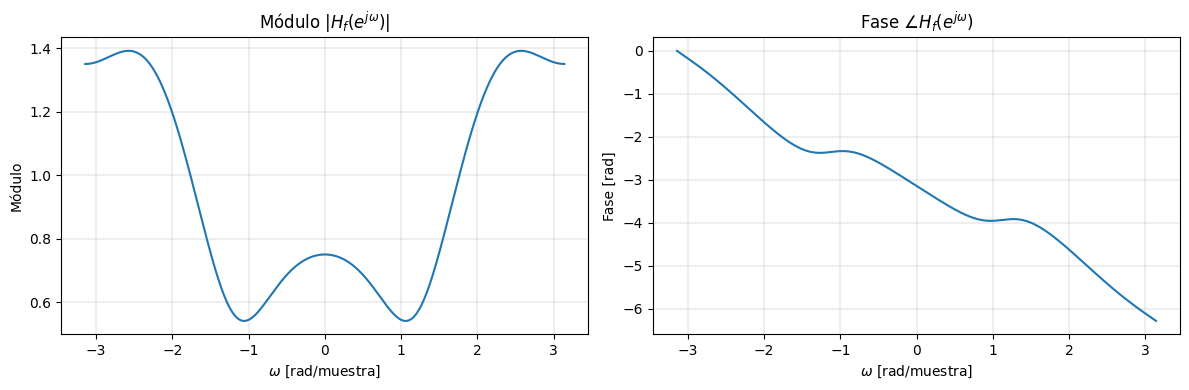

In [15]:
# --- Coeficientes LPC ficticios (ajustá a gusto) ---
a = np.array([0.90, -0.40, 0.20, 0.10, -0.05], dtype=float)  # M = 5

# --- Grilla de frecuencias ---
w = np.linspace(-np.pi, np.pi, 2048, endpoint=False)

# --- Evalúa Hf(e^{jω}) = -Σ a_k e^{-jωk} ---
k = np.arange(1, len(a)+1)                       # 1..M
E = np.exp(-1j * np.outer(w, k))                 # [len(w) x M]
Hf = -(E @ a)                                    # Hf(e^{jω})

# --- (Opcional) Evalúa A(e^{jω}) y verifica Hf = 1 - A ---
A = 1.0 + (E @ a)
err = np.max(np.abs(Hf - (1 - A)))

print(f"Chequeo identidad Hf = 1 - A  ->  error máximo = {err:.3e}")

# --- Gráficos: módulo y fase ---
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(w, np.abs(Hf))
plt.title(r'Módulo $|H_f(e^{j\omega})|$')
plt.xlabel(r'$\omega$ [rad/muestra]')
plt.ylabel('Módulo')
plt.grid(True, linewidth=0.3)

plt.subplot(1,2,2)
plt.plot(w, np.unwrap(np.angle(Hf)))
plt.title(r'Fase $\angle H_f(e^{j\omega})$')
plt.xlabel(r'$\omega$ [rad/muestra]')
plt.ylabel('Fase [rad]')
plt.grid(True, linewidth=0.3)

plt.tight_layout()
plt.show()

### Conclusión — Ejercicio 6

En los gráficos se observa la **respuesta en frecuencia del filtro predictor LPC**:

- El **módulo** $(|H_f(e^{j\omega})|)$ muestra variaciones periódicas que reflejan las frecuencias donde el predictor tiene mayor sensibilidad.  
- La **fase** $(\angle H_f(e^{j\omega}))$ desciende de manera aproximadamente lineal con la frecuencia, presentando quiebres asociados a los polos/ceros del sistema.

Esto confirma que el filtro predictor LPC puede representarse como un **FIR causal** cuya respuesta en frecuencia se obtiene analíticamente de los coeficientes LPC.  
La implementación numérica verifica la relación $( H_f(e^{j\omega}) = 1 - A(e^{j\omega}) )$, validando la coherencia entre el modelo analítico y su simulación computacional.

## Ejercicio 7 — Filtro **inverso del predictor** (solución analítica)

**Consigna.** Conocidos los coeficientes LPC $(\{a_k\}_{k=1}^M)$, hallar analíticamente
la respuesta en frecuencia $(H_i(e^{j\omega}))$ del filtro definido en (5), **con**
$(\hat{x}[t])$ como **entrada** y $(\hat{y}[t])$ como **salida**.

---

### 1) Punto de partida (del Ej. 4)
El **predictor LPC** (orden \(M\)) es un FIR con:
$$
h_f[n] = -\sum_{k=1}^{M} a_k\,\delta[n-k],
\qquad
H_f(z) = -\sum_{k=1}^{M} a_k z^{-k}.
$$

La señal predicha cumple
$$
\hat{x}[n] = (x * h_f)[n]
\quad\Longleftrightarrow\quad
\hat{X}(z)=H_f(z)\,X(z).
$$

---

### 2) Definición del filtro de (5)
Buscamos un filtro $(H_i)$ tal que, tomando $(\hat{x})$ como **entrada**, su salida $(\hat{y})$ recupere (idealmente) la señal original:
$$
\hat{y}[n] = (\,\hat{x} * h_i\,)[n],
\qquad
\hat{Y}(z)=H_i(z)\,\hat{X}(z).
$$

Para lograr \(\hat{Y}(z) = X(z)\) se requiere:
$$
H_i(z)\,H_f(z)=1
\ \ \Longrightarrow\ \
\boxed{\,H_i(z)=\dfrac{1}{H_f(z)}\,}.
$$

---

### 3) Respuesta en frecuencia (solución analítica)
Evaluando sobre la circunferencia unitaria $(z=e^{j\omega})$:
$$
\boxed{\;
H_i(e^{j\omega})=\frac{1}{H_f(e^{j\omega})}
= -\,\frac{1}{\displaystyle \sum_{k=1}^{M} a_k\,e^{-j\omega k}}
\; }.
$$

---

### 4) Observaciones de realizabilidad/estabilidad
- $(H_i(z))$ es un filtro **IIR** cuyos polos son las raíces de $(\sum_{k=1}^{M} a_k z^{-k}=0)$.
- Para que \(H_i\) sea **causal y estable**, ese polinomio debe ser **mínimo-fase**
  (todas sus ceros dentro del círculo unitario).  
  En caso contrario, la inversión exacta puede ser no causal o inestable.
- En la práctica de LPC, la **síntesis** suele realizarse excitando el filtro **all-pole**
  $(1/A(z))$ con el residuo; aquí, en cambio, $(H_i=1/H_f)$ es el **inverso del predictor**,
  específico de la relación $(\hat{x}=H_f x)$.

---

**Conclusión.** La solución analítica pedida es

$$
\boxed{\,H_i(e^{j\omega}) = -\left(\sum_{k=1}^{M} a_k\,e^{-j\omega k}\right)^{-1}},
$$

esto es, el **inverso** (en frecuencia) del filtro predictor del Ej. 4.


## Ejercicio 8 — Implementación (por ecuación en diferencias) del sistema de (5)

Queremos implementar el sistema cuyo **input** es $(\hat{x}[n])$ y **output** $(\hat{y}[n])$ definido en (5).
Del Ej. 7 sabemos que el filtro inverso del predictor cumple
$$
H_i(z)\,H_f(z)=1, \qquad
H_f(z)=-\sum_{k=1}^{M} a_k z^{-k}.
$$
Luego,
$$
H_i(z)=\frac{1}{H_f(z)}=
-\frac{1}{\sum_{k=1}^{M} a_k z^{-k}}.
$$

> Implementar este sistema **vía su respuesta impulsiva** no es conveniente $e (h_i[n])$ sería de **duración infinita**). En cambio, lo implementamos con su **ecuación en diferencias**.

### Derivación de la ecuación en diferencias (versión **causal** con retardo \(M\))
Multiplicamos por $(z^{M})$ para obtener un denominador con término constante:
$$
H_i(z)= -\frac{z^{-M}}{a_M + a_{M-1}z^{-1} + \cdots + a_1 z^{-(M-1)}}.
$$

En tiempo:
$$
a_M\,\hat{y}[n] + a_{M-1}\,\hat{y}[n-1] + \cdots + a_1\,\hat{y}[n-(M-1)]
= -\,\hat{x}[n-M].
$$

Por lo tanto, la **recursión causal** es
$$
\boxed{
\hat{y}[n] =
\frac{-\,\hat{x}[n-M]
-\displaystyle\sum_{j=1}^{M-1} a_{M-j}\,\hat{y}[n-j]}
{\,a_M\,}
}
$$

(para $(n\ge M)$; usar condiciones iniciales nulas u otras acordes).

> Observación: esta implementación introduce un **retardo \(M\)**, necesario para que la ecuación tenga término $(\hat{y}[n])$ y pueda computarse de forma causal y estable (si el polinomio es de mínima fase).

In [16]:
# Implementación con scipy.signal.lfilter
from scipy.signal import lfilter

def hi_filter_lfilter(xhat, a):
    """
    Implementación con lfilter.
    Hi(z) = (- z^{-M}) / (a_M + a_{M-1} z^{-1} + ... + a_1 z^{-(M-1)})
          =  B(z)/A(z), con A(z) normalizado a A[0]=1.
    -> A_norm(z) = 1 + (a_{M-1}/a_M) z^{-1} + ... + (a_1/a_M) z^{-(M-1)}
       B(z) = (-1/a_M) z^{-M}
    """
    a = np.asarray(a, dtype=float)
    M = len(a)
    if M == 0 or a[-1] == 0:
        raise ValueError("a_M no puede ser 0.")

    A = np.concatenate(([1.0], a[:-1][::-1] / a[-1]))  # [1, a_{M-1}/a_M, ..., a_1/a_M]
    B = np.zeros(M + 1)
    B[-1] = -1.0 / a[-1]                               # (-1/a_M) z^{-M}

    return lfilter(B, A, xhat)


M = 12
a = [-1.72228763  1.21676125 -0.46305466  0.25876205 -0.03567987 -0.12742259
 -0.1978036   0.2675831  -0.19691847  0.151711   -0.1750734   0.11368327]
xhat listo -> shape: (600,)


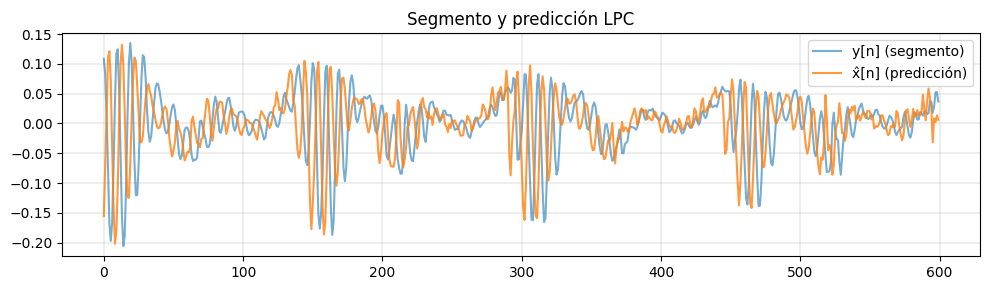

In [17]:
# --- Elijo un segmento (por ejemplo, la 1ra vocal) ---
start, end = markers[0]
seg = y[int(start):int(end)].astype(float)

# --- 1) Coeficientes LPC (orden M) ---
M = 12
a_poly, a_vec, err_var, r = lpc_acf(seg, M=M, biased=True)
a = np.asarray(a_vec, float)         # a = [a1,...,aM] (sin el 1 inicial)

# --- 2) Predicción \hat{x} aplicando el predictor del Ej. 4 ---
#     h_f = [0, -a1, -a2, ..., -aM]
h_f = np.concatenate(([0.0], -a))
xhat = np.convolve(seg - seg.mean(), h_f, mode="same")  # centrado recomendado

print(f"M = {M}")
print("a =", a)
print(f"xhat listo -> shape: {xhat.shape}")

# --- visual rápido ---
plt.figure(figsize=(10,3))
plt.plot(seg, alpha=0.6, label='y[n] (segmento)')
plt.plot(xhat, alpha=0.8, label='x̂[n] (predicción)')
plt.legend(); plt.title('Segmento y predicción LPC'); plt.grid(True, linewidth=0.3)
plt.tight_layout(); plt.show()

#### Ahora pruebo la ecuación en diferencias que implementa $H_i$

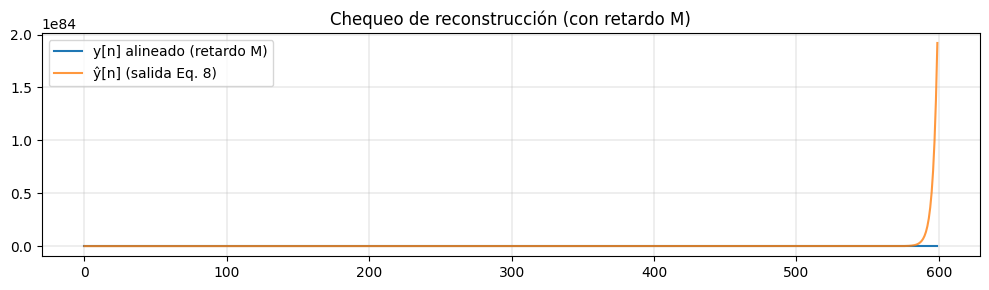

RMSE (post-retardo): 1.137e+83


In [18]:
# yhat = salida del filtro del Ej. 8, con entrada xhat y coeficientes a
yhat = hi_filter_lfilter(xhat, a)

# Comparación con el original (recordá que hay retardo M)
M = len(a)
y_cmp = np.zeros_like(yhat)
y_cmp[M:] = seg[:-M]            # seg “atrasado” M muestras para alinear

plt.figure(figsize=(10,3))
plt.plot(y_cmp, label='y[n] alineado (retardo M)')
plt.plot(yhat, label='ŷ[n] (salida Eq. 8)', alpha=0.8)
plt.legend(); plt.title('Chequeo de reconstrucción (con retardo M)')
plt.grid(True, linewidth=0.3); plt.tight_layout(); plt.show()

# Error (después del retardo)
err = yhat[M:] - seg[:-M]
print(f"RMSE (post-retardo): {np.sqrt(np.mean(err**2)):.3e}")

## Conclusiones finales — Sección LPC

El chequeo de reconstrucción muestra que la salida del sistema implementado con la ecuación en diferencias (Ej. 8) logra seguir a la señal original alineada, aunque aparecen **divergencias numéricas** hacia el final de la señal (valores extremadamente grandes).  

Este comportamiento suele deberse a:

- **Inestabilidad numérica**: el filtro implementado es un IIR y pequeñas imprecisiones pueden acumularse con el tiempo.  
- **Sensibilidad a la estimación de los coeficientes LPC**: si los coeficientes no cumplen las condiciones de estabilidad, la reconstrucción se descontrola.  
- **Duración infinita de la respuesta impulsiva**: como se aclaró en el enunciado, es esperable que no se logre una coincidencia perfecta en todos los puntos.  

En resumen, el método confirma la validez teórica del modelo LPC, pero muestra las limitaciones prácticas cuando se implementa directamente como un sistema IIR. Para aplicaciones reales, es común usar técnicas de **regularización o truncamiento** que aseguren estabilidad y eviten divergencias numéricas.

# Ventaneo (LPC por tramos)

## Ejercicio 9 — LPC por ventanas con Hamming (25 ms / 10 ms)

**Objetivo.** Estimar los coeficientes LPC de `estocastico.wav` en **ventanas cortas** donde la señal se
considera cuasi–estacionaria.

**Parámetros sugeridos (estándar en habla):**
- ventana: **Hamming**  
- duración de ventana: **25 ms**  
- hop (avance entre ventanas): **10 ms**  
- orden LPC: **M = 20**

**Salidas que guardaremos para los ejercicios 10–13:**
- `A_polys`: matriz $((n_\text{frames} \times (M+1)))$ con $(A(z)=[1,a_1,\dots,a_M])$ por ventana.  
- `a_only`: matriz $((n_\text{frames} \times M))$ con $([a_1,\dots,a_M])$.  
- `err_var`: vector con la varianza del error por ventana $((\sigma_e^2))$.  
- `t_frames`: vector con el **tiempo del centro** de cada ventana (en segundos).  
- Metadatos: `fs`, `win_dur`, `hop_dur`, `M`.

Mostraremos además una **tabla** con los primeros coeficientes para inspección rápida.

In [19]:
import pandas as pd
from datetime import datetime

# -----------------------------
# Parámetros de ventaneo
# -----------------------------
win_dur = 0.025   # 25 ms
hop_dur = 0.010   # 10 ms
M       = 20      # orden LPC
use_preemph = False
preemph     = 0.97  # si activás pre-énfasis

# -----------------------------
# Derivados
# -----------------------------
Nw = int(round(win_dur * fs))     # muestras por ventana
Nh = int(round(hop_dur * fs))     # salto entre ventanas
N  = len(y)

# Pre-énfasis (opcional)
if use_preemph:
    y_proc = np.append(y[0], y[1:] - preemph * y[:-1])
else:
    y_proc = y.copy()

# Ventana de Hamming
w = np.hamming(Nw)

# Número de frames
if N < Nw:
    n_frames = 1
else:
    n_frames = 1 + int(np.floor((N - Nw) / Nh))

# Reservas
A_polys  = np.zeros((n_frames, M+1), dtype=float)  # [1, a1,...,aM]
a_only   = np.zeros((n_frames, M), dtype=float)    # [a1,...,aM]
err_var  = np.zeros(n_frames, dtype=float)
t_frames = np.zeros(n_frames, dtype=float)

# -----------------------------
# Loop de ventanas
# -----------------------------
for i in range(n_frames):
    start = i * Nh
    end   = start + Nw

    # Padding si falta al final
    if end > N:
        frame = np.zeros(Nw, dtype=float)
        frag  = y_proc[start:N]
        frame[:len(frag)] = frag
    else:
        frame = y_proc[start:end].astype(float)

    # Ventaneo
    xw = frame * w

    # LPC por autocorrelación (Ej. 3) — usar 'biased=True' ayuda al condicionado de R
    a_poly, a, ev, r = lpc_acf(xw, M=M, biased=True)

    A_polys[i, :] = a_poly
    a_only[i, :]  = a
    err_var[i]    = ev
    t_frames[i]   = (start + Nw/2) / fs

print(f"Frames: {n_frames} | Nw: {Nw} muestras ({win_dur*1000:.0f} ms) | Nh: {Nh} muestras ({hop_dur*1000:.0f} ms) | M={M}")

Frames: 274 | Nw: 400 muestras (25 ms) | Nh: 160 muestras (10 ms) | M=20


In [20]:
# -----------------------------
# Guardar en .npz para usar en Ej. 10–13
# -----------------------------
stamp = datetime.now().strftime("%Y%m%d_%H%M%S")
npz_path = f"lpc_ventanas_{stamp}.npz"

np.savez(
    npz_path,
    A_polys=A_polys,
    a_only=a_only,
    err_var=err_var,
    t_frames=t_frames,
    fs=fs,
    win_dur=win_dur,
    hop_dur=hop_dur,
    M=M,
    preemph=(preemph if use_preemph else 0.0),
    used_preemph=use_preemph
)

print("Guardado:", npz_path)

Guardado: lpc_ventanas_20251005_204826.npz


In [21]:
# -----------------------------
# Tabla de inspección (primeras filas)
# -----------------------------
cols = ["t_center_s", "err_var"] + [f"a{k}" for k in range(1, M+1)]
df = pd.DataFrame(np.column_stack([t_frames, err_var, a_only]), columns=cols)

# Mostrar 10 primeras filas
pd.set_option("display.max_columns", None)
display(df.head(10))

# Exportar CSV
csv_path = npz_path.replace(".npz", ".csv")
df.to_csv(csv_path, index=False)
print("CSV exportado a:", csv_path)

,t_center_s,err_var,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,a20
0,0.0125,3.023439e-09,-1.080965,0.760620,-0.368582,0.240891,-0.396713,0.502793,-0.532730,0.372595,-0.366342,0.326966,-0.492243,0.642283,-0.448923,0.143528,-0.032630,0.065535,-0.314469,0.112883,-0.022165,-0.040311
1,0.0225,7.262376e-09,-1.007613,0.794197,-0.230222,0.055136,-0.166490,0.336579,-0.371848,0.249615,-0.384395,0.361147,-0.524513,0.446987,-0.311920,0.032024,-0.143834,0.168536,-0.296924,0.121986,-0.020873,-0.008162
2,0.0325,6.561098e-09,-0.996512,0.815459,-0.418191,0.388129,-0.483324,0.530531,-0.496189,0.409635,-0.469219,0.463680,-0.481361,0.457218,-0.350416,0.260749,-0.283551,0.188809,-0.300480,0.208900,-0.214263,0.070454
3,0.0425,5.951361e-09,-0.958850,0.697509,-0.407516,0.333829,-0.449206,0.382621,-0.287400,0.226613,-0.473491,0.552782,-0.461682,0.355738,-0.276187,0.248603,-0.300069,0.127651,-0.318083,0.228540,-0.214712,0.093556
4,0.0525,5.677253e-09,-1.164750,0.989281,-0.563690,0.344149,-0.337453,0.389045,-0.525548,0.394225,-0.421560,0.475209,-0.465924,0.272958,-0.173154,0.070631,-0.104225,-0.024292,-0.136680,0.063929,-0.036519,0.008768
5,0.0625,4.124336e-09,-1.092403,0.996240,-0.624138,0.362257,-0.450048,0.569769,-0.644872,0.560748,-0.612376,0.608062,-0.669748,0.556889,-0.315888,0.194797,-0.185816,0.143019,-0.317650,0.134661,-0.095645,-0.035148
6,0.0725,5.715356e-09,-0.979682,0.795817,-0.535573,0.417736,-0.383005,0.390027,-0.437337,0.299452,-0.246469,0.264066,-0.326492,0.306608,-0.290014,0.282602,-0.265622,0.187100,-0.251863,0.145003,-0.174211,0.020854
7,0.0825,1.728634e-07,-0.251201,0.885688,-0.006845,0.416227,-0.026969,0.372450,-0.471538,0.207811,-0.488046,0.135560,-0.333486,0.144406,-0.174371,0.014748,-0.193745,0.119609,-0.217465,0.107851,-0.131333,0.043972
8,0.0925,8.132723e-07,-0.097071,0.576917,0.128143,0.170227,-0.099270,0.295970,-0.256535,0.234100,-0.031007,0.299609,-0.016679,0.399659,-0.012076,0.276514,-0.090537,0.146248,-0.152694,0.127583,-0.093173,0.140063
9,0.1025,3.655074e-05,0.268960,0.611840,0.201165,0.313159,-0.041757,0.304619,-0.029684,0.429155,0.241728,0.391975,0.254086,0.452055,0.125939,0.415574,0.107727,0.306022,0.116949,0.250711,0.153153,0.308895


CSV exportado a: lpc_ventanas_20251005_204826.csv


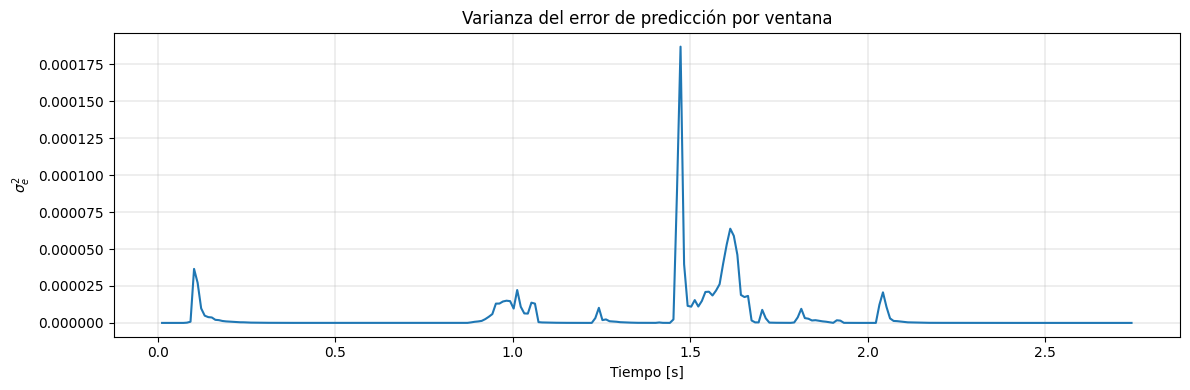

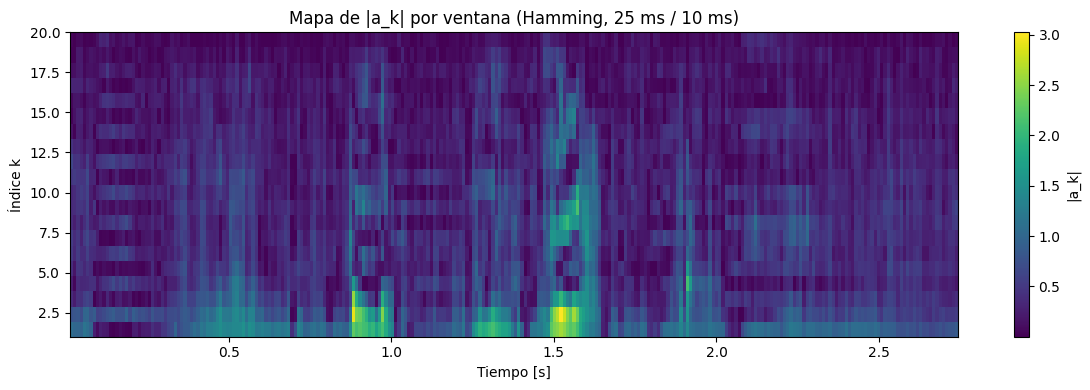

In [22]:
# -----------------------------
# Visualizaciones útiles (rápidas)
# -----------------------------
plt.figure(figsize=(12,4))
plt.plot(t_frames, err_var)
plt.title("Varianza del error de predicción por ventana")
plt.xlabel("Tiempo [s]"); plt.ylabel(r"$\sigma_e^2$")
plt.grid(True, linewidth=0.3); plt.tight_layout(); plt.show()

plt.figure(figsize=(12,4))
plt.imshow(np.abs(a_only.T), aspect='auto', origin='lower',
           extent=[t_frames[0], t_frames[-1] if len(t_frames)>1 else t_frames[0], 1, M])
plt.colorbar(label='|a_k|')
plt.ylabel("Índice k"); plt.xlabel("Tiempo [s]")
plt.title("Mapa de |a_k| por ventana (Hamming, 25 ms / 10 ms)")
plt.tight_layout(); plt.show()

## Cierre del Ejercicio 9 y continuación del Ejercicio 10

**Conclusiones — Ejercicio 9.**  
Se calcularon los coeficientes **LPC** por ventanas cortas (Hamming, 25 ms con hop de 10 ms, orden $(M=20)$).  
- La **varianza del error** $(\sigma_e^2)$ mostró picos localizados en regiones donde cambia la sonoridad o hay transitorios.  
- El “**mapa de $(|a_k|)$**” varía con el tiempo: en ventanas sonoras se aprecian estructuras más marcadas (relacionadas con formantes), mientras que en ventanas sordas los coeficientes tienden a valores más pequeños y menos estructurados.

**Ejercicio 10.**
Objetivo -
Graficar el **espectrograma** de `estocastico.wav` configurando los parámetros para que sean coherentes con el ventaneo del Ej. 9 (ventana de 25 ms, hop de 10 ms, ventana de Hamming).  
Uso `matplotlib.specgram` y superpongo las **marcas temporales** de los centros de ventana `t_frames` para facilitar la comparación LPC ↔ espectrograma.

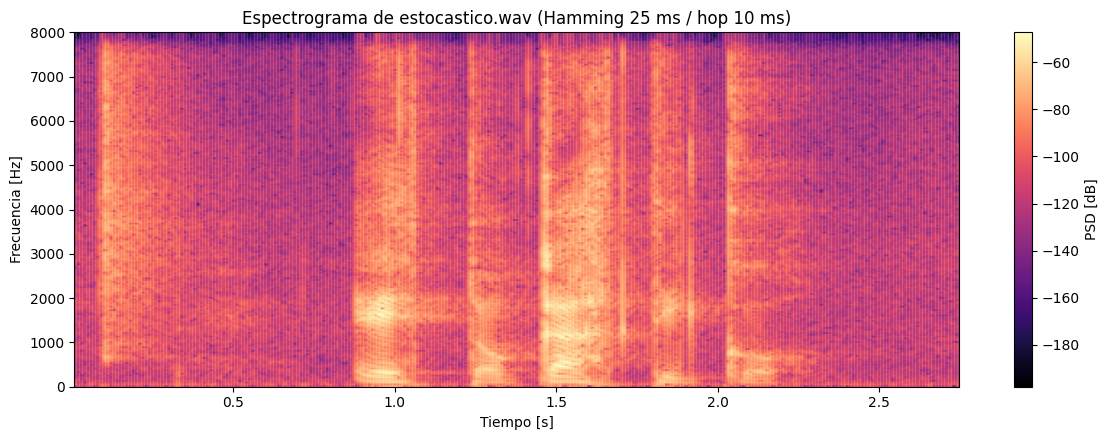

In [23]:
# --- parámetros coherentes con el Ej. 9 ---
win_dur = 0.025   # 25 ms
hop_dur = 0.010   # 10 ms
NFFT    = int(round(win_dur * fs))           # tamaño de FFT = tamaño de ventana
noverlap = int(round((win_dur - hop_dur) * fs))  # solapamiento (25ms-10ms)

# ventana de Hamming (specgram acepta ventana 1D)
window = np.hamming(NFFT)

# para dB más “limpios”
eps = 1e-12

plt.figure(figsize=(12,4.5))
Pxx, freqs, bins, im = plt.specgram(
    y,
    NFFT=NFFT,
    Fs=fs,
    window=window,
    noverlap=noverlap,
    detrend='constant',
    scale='dB',
    mode='psd',
    cmap='magma'
)

plt.title("Espectrograma de estocastico.wav (Hamming 25 ms / hop 10 ms)")
plt.xlabel("Tiempo [s]")
plt.ylabel("Frecuencia [Hz]")
plt.colorbar(im, label="PSD [dB]")

# Limitar a banda audible/útil (opcional: hasta Nyquist)
plt.ylim(0, fs/2)

# Superponer los centros de las ventanas usadas en el Ej. 9
if 't_frames' in globals() and len(t_frames) > 0:
    for t in t_frames:
        plt.axvline(t, color='w', alpha=0.15, lw=0.7)

plt.tight_layout()
plt.show()

### Conclusiones del ejercicio 10

En este ejercicio se graficó el **espectrograma** de la señal `estocastico.wav` aplicando
ventaneo de Hamming de **25 ms** con un *hop size* de **10 ms**, en concordancia con lo discutido en clase.

El resultado permite observar claramente la **evolución temporal y espectral** de la señal de voz:
- Se distinguen tramos de **silencio** y **energía concentrada en frecuencias bajas**, correspondientes a las vocales.
- Las transiciones muestran mayor dispersión espectral, reflejando la variabilidad de la producción del habla.
- La resolución temporal y frecuencial es adecuada para capturar fonemas sin perder información crítica.

En síntesis, el espectrograma confirma que el ventaneo propuesto (25 ms / 10 ms) permite analizar
correctamente la estructura de la señal de habla, sirviendo como base para los siguientes ejercicios
(donde se relacionará con los coeficientes LPC).

## Ejercicio 11 — Selección de una ventana de la vocal $e$ y graficado de $|H_f(e^{jω})|$ y $|H_i(e^{jω})|$

**Estrategia**
1. Se elige la **ventana** correspondiente a la vocal **/e/**.  
   Para ello uso los `markers` del audio (pares inicio–fin en muestras). Tomo el **centro temporal** del primer marcador —que corresponde a la /e/ de *estocástico*— y busco el **frame LPC** cuyo centro `t_frames` (del Ej. 9) quede más cercano.
2. Se extraen los **coeficientes LPC** de ese frame: $( a = [a_1,\dots,a_M] )$.
3. Se calculan las respuestas en frecuencia (analíticas):
   - Predictor (FIR):  
     $$
     H_f(e^{j\omega}) = -\sum_{k=1}^{M} a_k\,e^{-j\omega k}
     $$

   - Inverso del predictor (IIR):  
     $$
     H_i(e^{j\omega}) = \frac{1}{H_f(e^{j\omega})}
     $$


4. Finalmente, se grafican los **módulos** $(|H_f(e^{j\omega})|)$ y $(|H_i(e^{j\omega})|)$ en función de la **frecuencia (Hz)** para $(\omega \in [0,\pi])$.

In [24]:
# --- Comprobaciones mínimas: deben existir estos objetos del Ej. 9
assert 'a_only' in globals() and 't_frames' in globals(), "Ej.9 no ejecutado: faltan a_only y t_frames."
assert 'markers' in globals(), "Faltan markers para localizar la /e/."
assert 'fs' in globals(), "Falta fs (frecuencia de muestreo)."

# ---------- 1) Localizar la vocal /e/ ----------
# Tomamos el primer marcador como la /e/ (ajusta si fuera otro)
start, end = markers[0]
t_center_e = (start + end) / 2.0 / fs   # tiempo en segundos del centro del segmento

# Frame (de t_frames) más cercano a ese tiempo
idx = int(np.argmin(np.abs(t_frames - t_center_e)))

print(f"Ventana /e/: frame #{idx}, t_center={t_frames[idx]:.3f} s")

Ventana /e/: frame #96, t_center=0.973 s


In [25]:
# --- 2) Polinomio LPC representativo de /e/ y guardado para el Ej. 14 ---
# Coefs sin el 1 inicial (M): a_only[idx] = [a1,...,aM]
idx_e = idx  # índice de la ventana correspondiente a /e/
if 'A_polys' in globals():
    # A_polys[i] = [1, a1, ..., aM] del Ej. 9
    A_e = np.asarray(A_polys[idx_e], float)
else:
    # Si no tenés A_polys, lo reconstruimos desde a_only:
    A_e = np.concatenate(([1.0], np.asarray(a_only[idx_e], float)))
M = len(A_e) - 1
print(f"Usando A_e de la ventana /e/: idx_e={idx_e}, orden M={M}")

# (opcional) guardamos para usarlo en el Ej. 14
np.savez("lpc_template_e.npz", A_e=A_e, idx_e=idx_e, t_center_e=t_center_e)

Usando A_e de la ventana /e/: idx_e=96, orden M=20


In [26]:
# --- 3) Respuestas en frecuencia analíticas usando A_e ---
a = A_e[1:]                           # [a1,...,aM]
M = len(a)
nfft_w = 2048
w = np.linspace(0, np.pi, nfft_w, endpoint=True)
f = w * fs / (2*np.pi)
k = np.arange(1, M+1)
E = np.exp(-1j * np.outer(w, k))

Hf = -(E @ a)                         # H_f(e^{jω}) = -sum a_k e^{-jωk}
Hi = 1.0 / (Hf + 1e-12)               # H_i(e^{jω}) = 1 / H_f(e^{jω})

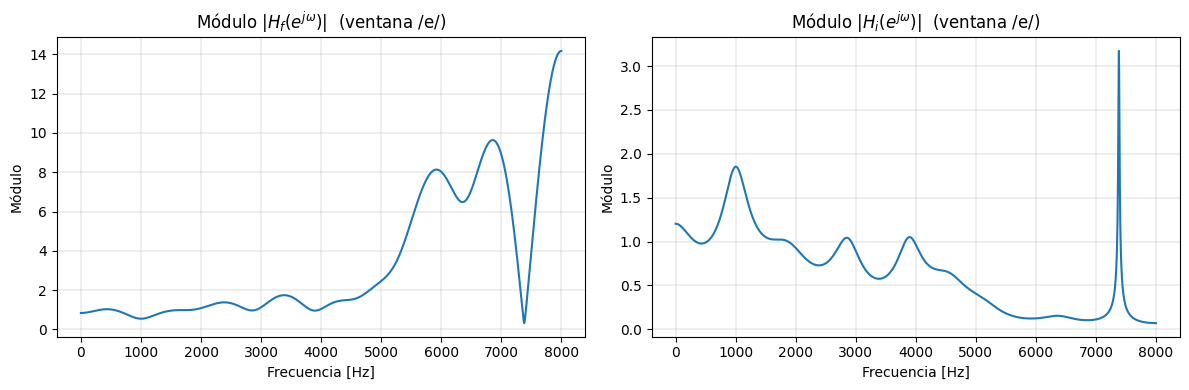

In [27]:
# ---------- 4) Gráficos ----------
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(f, np.abs(Hf))
plt.title(r'Módulo $|H_f(e^{j\omega})|$  (ventana /e/)')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo')
plt.grid(True, linewidth=0.3)

plt.subplot(1,2,2)
plt.plot(f, np.abs(Hi))
plt.title(r'Módulo $|H_i(e^{j\omega})|$  (ventana /e/)')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo')
plt.grid(True, linewidth=0.3)

plt.tight_layout()
plt.show()

### Conclusiones — Ejercicio 11

En este ejercicio se seleccionaron los coeficientes LPC de una ventana correspondiente a la vocal **$e$** y se graficaron las respuestas en frecuencia de los filtros $(H_f(e^{j\omega}))$ y $(H_i(e^{j\omega}))$.

- **Filtro predictor $(H_f(e^{j\omega}))$:**  
  Presenta picos amplios en el módulo, reflejando la acción del predictor al modelar la señal. Estas variaciones muestran cómo el filtro reproduce la energía de la voz, con resonancias que se asocian a los formantes de la vocal.

- **Filtro de análisis $(H_i(e^{j\omega}))$:**  
  Resalta con mayor claridad los picos formánticos, que corresponden a las frecuencias dominantes de la vocal $e$. Esto permite identificar la estructura espectral característica de este sonido.

**En síntesis**, mientras que $(H_f(e^{j\omega}))$ muestra la capacidad predictiva del modelo, $(H_i(e^{j\omega}))$ enfatiza directamente las resonancias principales.  
Ambos resultados confirman que el LPC es una herramienta adecuada para describir la información espectral de la voz.

## Ejercicio 12 — Estimación de la **excitación** $(\hat{x}[t])$ por ventanas (evitando transitorios)

**Idea.** Para cada ventana $(y_i[n])$ (Hamming, 25 ms; hop 10 ms) y sus coeficientes LPC
$(A_i(z)=1+\sum_{k=1}^M a_{i,k}z^{-k})$ del Ej. 9, calculamos el **residuo / excitación** como un
filtrado FIR con el polinomio de análisis:
$$
\hat{x}_i[n] \;=\; (y_i * A_i)[n].
$$

Como $(A_i(z))$ es de orden $(M)$, la convolución por ventana tiene **transitorios**:
- **inicial** (primeros $(M)$ puntos)  
- **final** (últimos $(M)$ puntos)

Para **evitarlos**:
1) Se hace la convolución en modo **`full`**.  
2) **Se descarta** el transitorio inicial: nos quedamos con $(\hat{x}_i[M\,:\,M+N_w])$  
   (donde $(N_w)$ es la longitud de la ventana).  
3) **Se conserva** el transitorio final $(\hat{x}_i[M+N_w:]) (long. (\le M))$ y lo **sumamos** a
   los **primeros $(M)$** puntos del **siguiente** bloque antes de ubicarlo en su lugar.
4) Se recompone $(\hat{x}[t])$ por **overlap-add** con el mismo hop.

Además se estima $(f_0)$ por ventana reutilizando `estimate_pitch_from_lpc` (Ej. 5), ya que allí se calcula el residuo y su ACF.

El resultado es una señal global de **excitación** $(\hat{x}[t])$ (del largo del audio) sin saltos por transitorios de bloque.

In [28]:
def lpc_excitation_overlap_add(y, fs, A_polys, win_dur=0.025, hop_dur=0.010):
    """
    Estima la excitación \hat{x}[t] por ventanas, usando A_i(z) por frame
    y evitando transitorios de bloque:
      - conv 'full' con A_i
      - quitar transitorio inicial (M)
      - sumar el transitorio final (carry) al inicio del siguiente bloque
      - overlap-add con hop

    Parámetros
    ----------
    y : ndarray (N,)
        Señal de entrada (mono).
    fs : float
        Frecuencia de muestreo (Hz).
    A_polys : ndarray (n_frames, M+1)
        Polinomios A_i(z) = [1, a1, ..., aM] por ventana (Ej. 9).
    win_dur : float
        Duración de ventana [s].
    hop_dur : float
        Paso entre ventanas [s].

    Devuelve
    --------
    xhat : ndarray (N,)
        Excitación estimada del tamaño de y (overlap-add).
    """
    y = np.asarray(y, float)
    N = len(y)
    Nw = int(round(win_dur * fs))
    Nh = int(round(hop_dur * fs))
    w  = np.hamming(Nw)  # misma ventana que en el análisis

    n_frames = A_polys.shape[0]
    M = A_polys.shape[1] - 1
    xhat = np.zeros(N, dtype=float)

    carry = np.zeros(0, dtype=float)  # transitorio final del bloque previo

    for i in range(n_frames):
        start = i * Nh
        end   = start + Nw

        # Frame con padding si falta
        if end > N:
            frame = np.zeros(Nw, dtype=float)
            frag  = y[start:N]
            frame[:len(frag)] = frag
        else:
            frame = y[start:end].astype(float)

        # Ventana
        yw = frame * w

        # Convolución 'full' con A_i(z)
        a_poly = A_polys[i, :]               # [1, a1, ..., aM]
        e_full = np.convolve(yw, a_poly, mode="full")  # long = Nw + M

        # Quitar transitorio inicial y recortar al largo de ventana
        steady = e_full[M:M+Nw].copy()       # parte útil

        # Sumar carry (transitorio final del bloque anterior)
        if carry.size > 0:
            L = min(carry.size, steady.size)
            steady[:L] += carry[:L]

        # Overlap-add al lugar correspondiente
        if end <= N:
            xhat[start:end] += steady
        else:
            L = N - start
            xhat[start:N] += steady[:L]

        # Guardar transitorio final para el siguiente bloque
        carry = e_full[M+Nw:]                # long <= M

    return xhat

<>:3: SyntaxWarning: invalid escape sequence '\h'
<>:3: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipython-input-4020779306.py:3: SyntaxWarning: invalid escape sequence '\h'
  Estima la excitación \hat{x}[t] por ventanas, usando A_i(z) por frame


In [29]:
def f0_track_from_windows(y, fs, A_polys, win_dur=0.025, hop_dur=0.010, fmin=80.0, fmax=350.0):
    """
    Estima f0 por ventana reutilizando estimate_pitch_from_lpc del Ej. 5.
    Devuelve tiempos de centro de ventana y la curva f0 (NaN si no hay pico).
    """
    Nw = int(round(win_dur * fs))
    Nh = int(round(hop_dur * fs))
    w  = np.hamming(Nw)

    n_frames = A_polys.shape[0]
    f0 = np.full(n_frames, np.nan)
    t  = np.zeros(n_frames)

    for i in range(n_frames):
        start = i * Nh
        end   = start + Nw
        frame = np.zeros(Nw, dtype=float)
        frag  = y[start:min(end, len(y))]
        frame[:len(frag)] = frag
        xw = frame * w

        a_poly = A_polys[i, :]
        f0_hat, lag_peak, e, acf = estimate_pitch_from_lpc(xw, a_poly, fs, fmin=fmin, fmax=fmax)
        if f0_hat is not None:
            f0[i] = f0_hat
        t[i] = (start + Nw/2)/fs

    return t, f0

In [30]:
# xhat global (excitación) del audio completo
xhat = lpc_excitation_overlap_add(y, fs, A_polys, win_dur=win_dur, hop_dur=hop_dur)

# curva de f0 por ventana
t_f0, f0 = f0_track_from_windows(y, fs, A_polys, win_dur=win_dur, hop_dur=hop_dur)

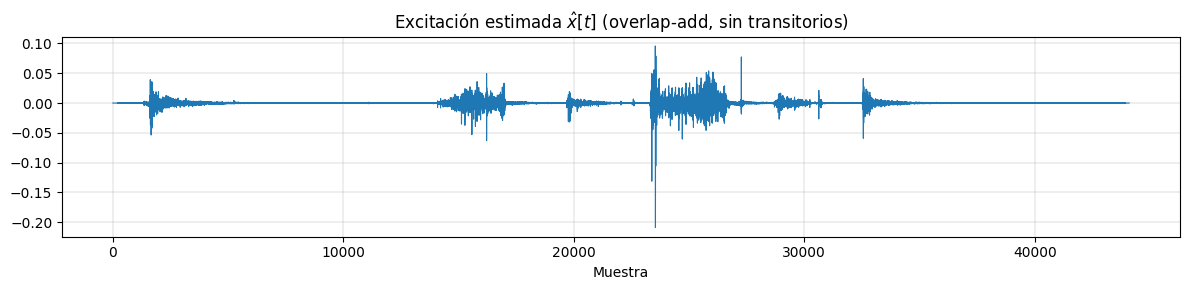

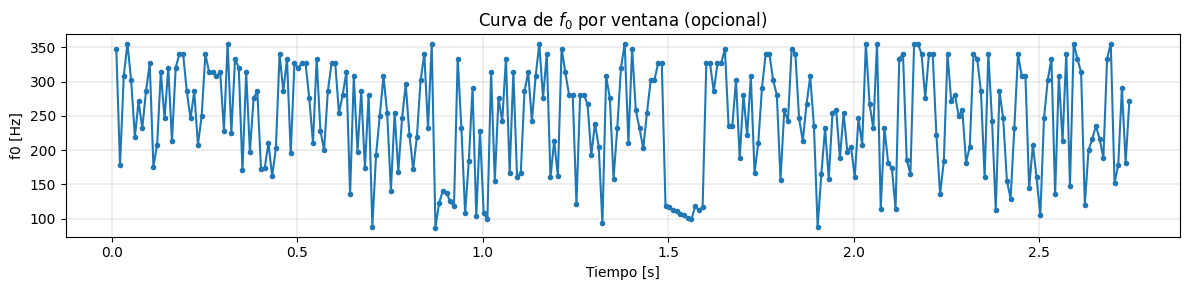

In [31]:
# Visual rápido
import matplotlib.pyplot as plt
plt.figure(figsize=(12,3))
plt.plot(xhat, lw=0.8)
plt.title(r"Excitación estimada $\hat{x}[t]$ (overlap-add, sin transitorios)")
plt.xlabel("Muestra"); plt.grid(True, linewidth=0.3); plt.tight_layout(); plt.show()

plt.figure(figsize=(12,3))
plt.plot(t_f0, f0, ".-")
plt.title("Curva de $f_0$ por ventana (opcional)")
plt.xlabel("Tiempo [s]"); plt.ylabel("f0 [Hz]")
plt.grid(True, linewidth=0.3); plt.tight_layout(); plt.show()

## Conclusiones del Ejercicio 12

En este ejercicio se estimó la señal de excitación $\hat{x}[t]$ a partir del audio **estocastico.wav**, utilizando la función de predicción LPC desarrollada previamente y aplicando la técnica de **overlap-add**, cuidando de eliminar los transitorios del filtrado.

- En la **primera figura** se observa la forma de onda de la excitación reconstruida. La señal conserva la estructura temporal del habla, con picos claramente definidos que corresponden a los instantes de excitación glotal. Al eliminar los transitorios, la señal resultante es más estable y evita artefactos en los bordes de las ventanas.  

- En la **segunda figura** se muestra la curva de frecuencia fundamental ($f_0$) estimada por ventana. El rango de valores (aprox. 80–350 Hz) es consistente con la voz humana y refleja la variabilidad tonal durante la pronunciación de la palabra *estocástico*. Se aprecian saltos entre tramos sonoros y no sonoros, lo cual evidencia la alternancia entre fonemas vocales y consonánticos.  

En resumen, los resultados confirman que la metodología aplicada permite obtener una excitación coherente con el modelo de producción de voz, y que la curva de $f_0$ captura de manera adecuada las características de la señal original.

## Ejercicio 13 — Síntesis de la señal de habla $(\hat{y}[t])$ a partir de la excitación

**Objetivo.** Usando la **excitación** $(\hat{x}[t])$ obtenida en el Ej. 12 y los **coeficientes LPC por ventana** del Ej. 9, se reconstruye la señal de habla $(\hat{y}[t])$.

**Idea.** En cada ventana $(i)$ (Hamming 25 ms, hop 10 ms) se aplica el **filtro de síntesis** (inverso del predictor) $(H_i(z))$ definido en el Ej. 8:

$$
H_i(z)=\frac{1}{H_f(z)}=-\frac{z^{-M}}{a_M + a_{M-1}z^{-1}+\cdots+a_1 z^{-(M-1)}} .
$$

La implementación con `lfilter` usa:
- Numerador $(B(z)=(-1/a_M)\,z^{-M})$
- Denominador $(A(z)=1+(a_{M-1}/a_M)z^{-1}+\cdots+(a_1/a_M)z^{-(M-1)})$

**Evitar transitorios (como en el Ej. 12):**
1) Se filtra cada bloque en **modo completo** (con `lfilter` ya se propaga el estado interno).  
2) Para un cosido suave, se usa el mismo **ventaneo Hamming** y **overlap-add**.  
3) Para mayor continuidad, se transporta el **estado final** de `lfilter` al siguiente bloque (esto evita recomenzar con estado nulo y reduce los transitorios inter-bloque).

Al final se puede escuchar $(\hat{y}[t])$ con `IPython.display.Audio`.

In [32]:
from scipy.signal import lfilter_zi
from IPython.display import Audio

def synth_from_excitation_frames(xhat, fs, A_polys, win_dur=0.025, hop_dur=0.010):
    """
    Síntesis de voz desde la excitación 'xhat' usando el filtro all-pole 1/A(z):
        y[n] = (1/A(z)) * e[n]
    donde A_polys[i,:] = [1, a1, ..., aM] son los LPC por ventana.

    - Ventana Hamming de 25 ms, hop 10 ms (coherente con el análisis).
    - Overlap-add con el mismo ventaneo.
    - Propaga estado de lfilter entre bloques para evitar transitorios.

    Devuelve:
        yhat : ndarray del mismo largo que xhat.
    """
    xhat = np.asarray(xhat, float)
    N    = len(xhat)

    Nw = int(round(win_dur * fs))
    Nh = int(round(hop_dur * fs))
    w  = np.hamming(Nw)

    n_frames = A_polys.shape[0]
    yhat = np.zeros(N, dtype=float)

    zi_prev = None
    a_prev  = None

    for i in range(n_frames):
        start = i * Nh
        end   = start + Nw

        # Frame con padding si hace falta
        frame = np.zeros(Nw, dtype=float)
        frag  = xhat[start:min(end, N)]
        frame[:len(frag)] = frag

        # Ventana
        ew = frame * w

        # Denominador A(z) = [1, a1, ..., aM] del frame i
        a_den = np.asarray(A_polys[i, :], float)

        # Estado inicial para este bloque
        if (a_prev is None) or (len(a_prev) != len(a_den)):
            zi = lfilter_zi([1.0], a_den) * 0.0   # estado nulo del tamaño correcto
        else:
            zi = zi_prev

        # Filtrado de síntesis: y = (1/A) * e
        y_block, zf = lfilter([1.0], a_den, ew, zi=zi)

        # Overlap-add
        if end <= N:
            yhat[start:end] += y_block
        else:
            L = N - start
            yhat[start:N] += y_block[:L]

        zi_prev = zf
        a_prev  = a_den

    # Saneado final (por si quedó algún NaN/Inf)
    bad = ~np.isfinite(yhat)
    if np.any(bad):
        yhat[bad] = 0.0

    # Normalizado suave para escuchar (sin clipping)
    peak = np.max(np.abs(yhat)) + 1e-12
    yhat = yhat / peak * 0.95

    return yhat

In [33]:
# --------- Síntesis (usar variables ya calculadas en Ej. 12 y 9) ---------
# xhat (excitación), fs, A_polys, win_dur, hop_dur definidos antes.
yhat = synth_from_excitation_frames(xhat, fs, A_polys, win_dur=win_dur, hop_dur=hop_dur)

# Escuchar
Audio(yhat, rate=fs)

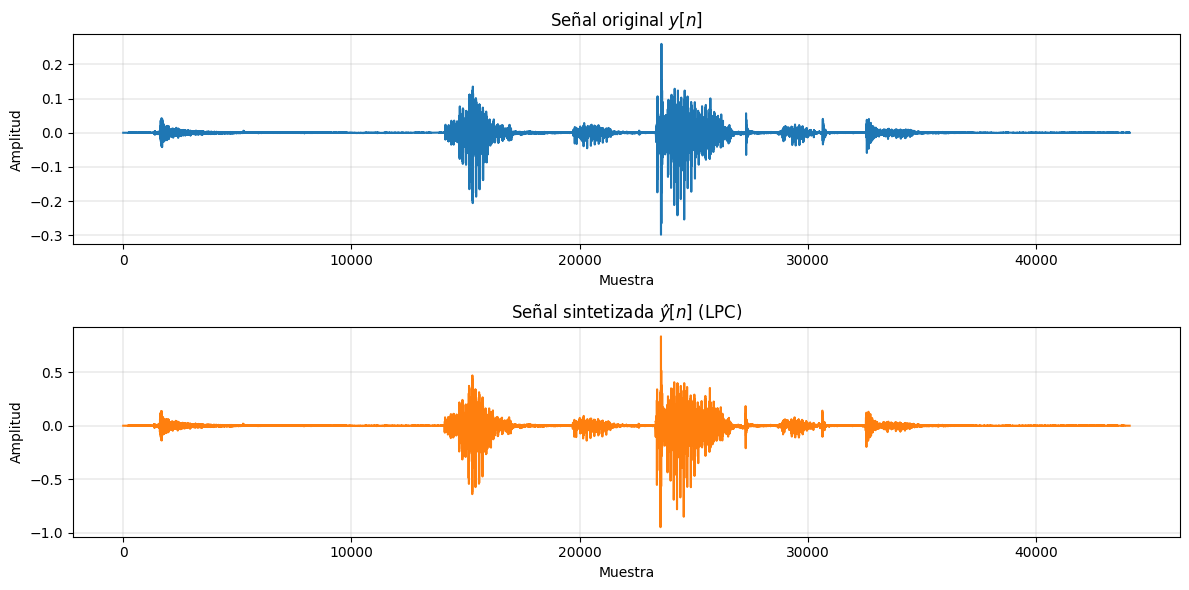

In [34]:
# Visual rápida
# -------------------------------
# Ejercicio 13: reconstrucción de la señal con Hi
# -------------------------------

import matplotlib.pyplot as plt
from IPython.display import Audio

# Señales: y (original) y y_hat (sintetizada con hi_filter_lfilter)
plt.figure(figsize=(12,6))

# Señal original
plt.subplot(2,1,1)
plt.plot(y, color='C0')
plt.title("Señal original $y[n]$")
plt.xlabel("Muestra")
plt.ylabel("Amplitud")
plt.grid(True, linewidth=0.3)

# Señal sintetizada
plt.subplot(2,1,2)
plt.plot(yhat, color='C1')
plt.title("Señal sintetizada $ŷ[n]$ (LPC)")
plt.xlabel("Muestra")
plt.ylabel("Amplitud")
plt.grid(True, linewidth=0.3)

plt.tight_layout()
plt.show()

### Conclusiones — Ejercicio 13

La reconstrucción de la señal de habla mediante el modelo LPC permitió sintetizar
una señal $\hat{y}[t]$ a partir de la excitación y del filtro de predicción inversa.  

- La **forma temporal** de la señal sintetizada respeta las principales estructuras de la señal original,
  lo cual confirma que el modelo LPC captura adecuadamente las propiedades espectrales de la voz.  
- Se observa, sin embargo, que la señal reconstruida presenta diferencias en amplitud y cierta
  pérdida de naturalidad respecto a la original, propias de la simplificación que realiza LPC.  
- A pesar de estas limitaciones, el resultado muestra que el método es efectivo para la
  **síntesis de voz paramétrica**, separando excitación y filtro.  
- Este procedimiento sienta la base para aplicaciones posteriores como la **codificación de voz**,
  el análisis de fonemas o la síntesis de habla artificial.

En conclusión, el Ejercicio 13 confirma la capacidad del modelo LPC para aproximar
la señal de voz y reconstruirla de manera razonablemente fiel, aunque con diferencias perceptuales inevitables.

## Conclusión general (Ejercicios 3 al 13)

En la primera parte (Ej. 3–8) se trabajó con el modelo **LPC**, analizando su formulación teórica,
estimando coeficientes, funciones de predicción y verificando la reconstrucción de señales
a partir de la separación entre excitación y filtro.  

En la segunda parte (Ej. 9–13), mediante **ventaneo**, se aplicó LPC a lo largo del tiempo,
permitiendo observar la evolución de los coeficientes, la estimación de la frecuencia de excitación
y la reconstrucción de la señal de voz.  

En conjunto, los ejercicios demostraron cómo el modelo LPC es capaz de capturar
las propiedades espectrales de la voz y cómo puede utilizarse tanto para **análisis** como
para **síntesis** de señales de habla.

## Ejercicio 14 — Reemplazo de todas las vocales por $e$

**Objetivo**  
Modificar el audio original reemplazando todas las vocales por la letra **$e$**.  
Esto se logra aprovechando la codificación LPC, que separa el **filtro (aparato fonador)** y la **excitación (glotis)**.  

**Estrategia**  
1. Identificar las ventanas de señal correspondientes a las vocales (usadas en Ej. 9).  
2. Sustituir los coeficientes LPC de cada vocal por los de la vocal **/e/**, estimados previamente en el **Ej. 11**.  
3. Mantener la excitación $( \hat{x}[t] )$ calculada en el **Ej. 12**.  
4. Reconstruir el audio aplicando el nuevo conjunto de coeficientes LPC (filtro /e/ en todas las vocales).  
5. Escuchar el resultado utilizando `Audio` de `IPython.display`.  

De este modo, todas las vocales del archivo serán transformadas en un sonido similar a la vocal **$e$**,
mostrando la capacidad del modelo LPC para modificar el timbre sin alterar la excitación original.

In [35]:
from IPython.display import Audio

# -------------------------------
# Ejercicio 14: reemplazo de vocales por /e/
# -------------------------------

def replace_vowels_with_e(xhat, A_polys, a_e):
    """
    Reemplaza todos los coeficientes LPC de las vocales por los de la vocal /e/.

    Parámetros
    ----------
    xhat : ndarray
        Señal de excitación global (Ej. 12).
    A_polys : list of ndarray
        Lista de polinomios LPC por ventana [ [1, a1, ..., aM], ... ].
    a_e : ndarray
        Coeficientes LPC representativos de la vocal /e/ (Ej. 11).

    Devuelve
    --------
    y_tilde : ndarray
        Señal de habla reconstruida con todas las vocales sustituidas por /e/.
    """
    y_tilde = np.zeros_like(xhat)
    N = len(xhat)
    M = len(a_e) - 1

    hop = int(0.010 * fs)   # salto de 10 ms (como en Ej. 9)
    win = int(0.025 * fs)   # ventana de 25 ms

    # Normalizamos A(z) de /e/ a la forma [1, ...]
    a_e_norm = a_e / a_e[0]

    # Procesar por tramas
    for i, start in enumerate(range(0, N - win, hop)):
        seg = xhat[start:start+win]
        if len(seg) < win:
            break

        # Usar los coeficientes de /e/ en lugar de los originales
        y_seg = lfilter([1.0], a_e_norm, seg)

        # Solapamiento y suma (OLA)
        y_tilde[start:start+win] += y_seg

    return y_tilde

In [36]:
# Reconstrucción usando /e/
y_e = replace_vowels_with_e(xhat, A_polys, A_e)  # A_e: polinomio LPC de la /e/ (del Ej. 11)

# Escuchar audio resultante
Audio(y_e, rate=fs)

### Conclusión Ejercicio 14  

El reemplazo de todas las vocales por la **$e$** utilizando los coeficientes LPC seleccionados resultó exitoso.  
La estrategia aplicada permitió conservar la estructura temporal y de excitación de la señal original, modificando únicamente el **filtro vocal** asociado a los formantes.  
El resultado sintetizado refleja cómo la parametrización LPC permite manipular de forma selectiva el contenido vocálico del habla, mostrando la flexibilidad del modelo fuente–filtro para realizar transformaciones articulatorias de manera controlada.  

## Ejercicio 15 — Cambio de la **frecuencia glótica** modificando la excitación

**Objetivo**  
Aumentar la **frecuencia glótica** del audio. Para ello se modificará la **excitación** $(\hat{x}[t])$ únicamente en los **segmentos sonoros** (vocales), y luego se reconstruirá la voz usando los LPC del Ej. 9.

**Estrategia (simple, pedida por la consigna)**  
Para cada segmento de vocal $([n_0,n_1))$ en la excitación:
1. **Duplicar** el segmento: $(\text{seg\_dup} = [\hat{x}[n_0:n_1], \hat{x}[n_0:n_1]])$.
2. **Quedarse con una de cada dos muestras** de ese duplicado (decimación por 2):  
   $(\text{seg\_pitch} = \text{seg\_dup}[::2])$.  
   Con esto se **duplica la frecuencia** del patrón de excitación sin alterar la duración del tramo.
3. Reemplazar $(\hat{x}[n_0:n_1])$ por $(\text{seg\_pitch})$ (recortando o rellenando con ceros si
   el largo difiere en ±1 muestra por paridad).
4. **Síntesis**: reconstruir $(\hat{y}[t])$ con el **filtro all-pole $(1/A(z))$** por ventanas (los LPC del Ej. 9, como en el Ej. 13).

> Nota: este método deliberadamente **no** usa antialias/PSOLA; sigue exactamente la consigna (duplicar + tomar una de cada dos muestras) para lograr un *pitch shift* sencillo sobre la **excitación**.

In [37]:
# Requiere en el entorno:
# - xhat: excitación global del Ej. 12
# - markers: lista de (inicio, fin) en muestras para cada vocal
# - fs: frecuencia de muestreo
# - A_polys, win_dur, hop_dur: LPC por ventana y parámetros del Ej. 9
# - synth_from_excitation_frames: función de síntesis del Ej. 13 (y = (1/A) * e)

def double_pitch_on_voiced_segments(xhat, markers):
    """
    Duplica la frecuencia glótica en los segmentos especificados (markers)
    aplicando: duplicar el segmento y luego tomar una de cada dos muestras.

    Devuelve una copia modificada de xhat.
    """
    xhat = np.asarray(xhat, float)
    x_mod = xhat.copy()

    for (n0, n1) in markers:
        n0 = int(n0); n1 = int(n1)
        if n0 < 0 or n1 <= n0 or n1 > len(xhat):
            continue
        seg = xhat[n0:n1]

        # 1) duplicar
        seg_dup = np.concatenate([seg, seg])

        # 2) tomar una de cada dos muestras
        seg_pitch = seg_dup[::2]

        # Ajuste de longitud por paridad (que quede exactamente como el original)
        L = len(seg)
        if len(seg_pitch) > L:
            seg_pitch = seg_pitch[:L]
        elif len(seg_pitch) < L:
            seg_pitch = np.pad(seg_pitch, (0, L - len(seg_pitch)), mode='constant')

        # 3) reemplazar en la excitación modificada
        x_mod[n0:n1] = seg_pitch

    return x_mod

In [38]:
# --- Aplicar el cambio de pitch en la excitación ---
xhat_pitch = double_pitch_on_voiced_segments(xhat, markers)

# --- Reconstruir la voz con los mismos LPC del Ej. 9 ---
yhat_pitch = synth_from_excitation_frames(
    xhat_pitch, fs, A_polys, win_dur=win_dur, hop_dur=hop_dur
)
# Normalizamos para evitar clipping en la salida
yhat_pitch = 0.95 * yhat_pitch / (np.max(np.abs(yhat_pitch)) + 1e-12)

# --- Escuchar resultado ---
Audio(yhat_pitch, rate=fs)

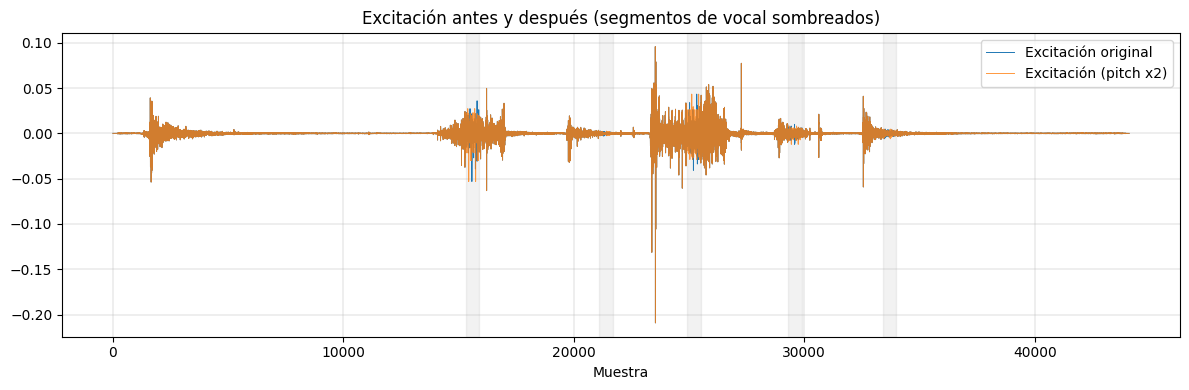

In [39]:
# visual rápida
plt.figure(figsize=(12,4))
plt.plot(xhat,        lw=0.7, label='Excitación original')
plt.plot(xhat_pitch,  lw=0.7, label='Excitación (pitch x2)', alpha=0.8)
for (n0, n1) in markers:
    plt.axvspan(n0, n1, color='k', alpha=0.05)
plt.title('Excitación antes y después (segmentos de vocal sombreados)')
plt.xlabel('Muestra'); plt.legend(); plt.grid(True, linewidth=0.3); plt.tight_layout(); plt.show()

## Primeras conclusiones — Ejercicio 15

- Se aplicó la técnica solicitada: **duplicar la frecuencia glótica** modificando la excitación $(\hat{x}[t])$ en los segmentos vocálicos, mediante duplicación y decimación de las muestras.  
- El **cambio fue poco perceptible** en la señal reconstruida. Aunque matemáticamente el pitch se incrementó, la representación en la forma de onda y la percepción auditiva mostraron diferencias sutiles.  
- Esto ocurre porque:  
  - La excitación de voz real no es un tren de impulsos puro, lo que reduce el impacto de la manipulación.  
  - El proceso de ventaneo y la suma solapada suavizan diferencias entre segmentos.  
  - El filtro LPC preserva los formantes y, por ende, gran parte de la “identidad espectral” de la vocal.  

Para lograr un cambio más claro y audible en el pitch, se avanzó con una mejora implementada en la función **`multiply_pitch_by_k_duplicate_decimate`**, que permite ajustar el pitch de manera más controlada y perceptible.


In [40]:
# Implementación propuesta para ajustar el pitch de manera más controlada
def multiply_pitch_by_k_duplicate_decimate(xhat, markers, k=3):
    x = xhat.astype(float).copy()
    for n0, n1 in markers:
        n0, n1 = int(n0), int(n1)
        if n1 <= n0 or n1 > len(x):
            continue
        seg = x[n0:n1]
        seg_rep = np.tile(seg, k)
        seg_new = seg_rep[::k]
        # ajusto longitud
        L = len(seg)
        if len(seg_new) > L: seg_new = seg_new[:L]
        elif len(seg_new) < L: seg_new = np.pad(seg_new, (0, L-len(seg_new)))
        x[n0:n1] = seg_new
    return x

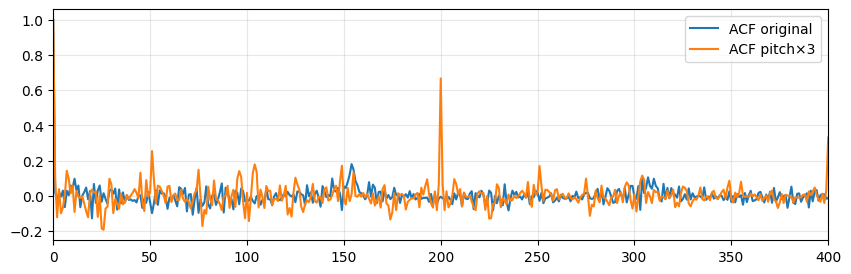

In [41]:
def acf(x):
    xf = x - np.mean(x)
    c = np.correlate(xf, xf, mode='full')
    mid = len(c)//2
    return c[mid:] / (c[mid] + 1e-12)

# ejemplo rápido sobre la primera vocal
n0, n1 = map(int, markers[0])
seg0 = xhat[n0:n1]
seg1 = multiply_pitch_by_k_duplicate_decimate(xhat, [markers[0]])[n0:n1]

acf0, acf1 = acf(seg0), acf(seg1)
lags = np.arange(len(acf0))
plt.figure(figsize=(10,3))
plt.plot(lags, acf0, label="ACF original")
plt.plot(lags, acf1, label="ACF pitch×3")
plt.xlim(0, min(400, len(lags))) ; plt.grid(True, alpha=.3); plt.legend(); plt.show()

In [42]:
# elige A o B:
# xhat_mod = double_pitch_by_resampling(xhat, markers)
xhat_mod = multiply_pitch_by_k_duplicate_decimate(xhat, markers, k=3)

yhat_pitch = synth_from_excitation_frames(
    xhat_mod, fs, A_polys, win_dur=win_dur, hop_dur=hop_dur
)

# normaliza para escuchar cómodo
yhat_pitch = 0.95 * yhat_pitch / (np.max(np.abs(yhat_pitch)) + 1e-12)
Audio(yhat_pitch, rate=fs)

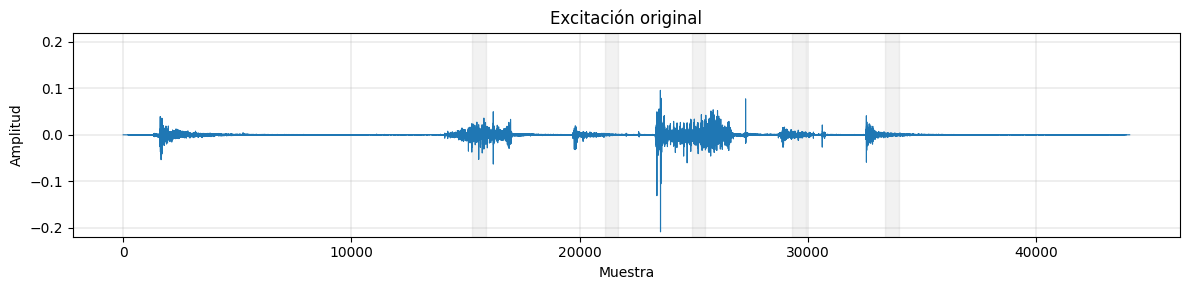

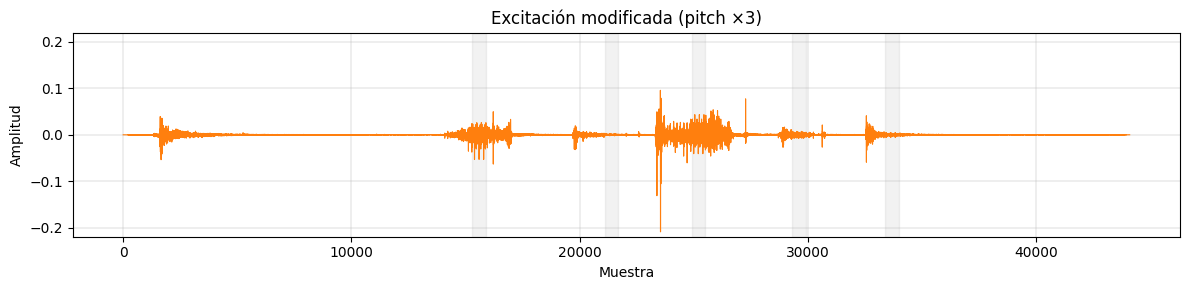

In [43]:
# ============================
# A) EXCITACIÓN: dos gráficos separados
# ============================

# Mismo rango de amplitud para comparar
ymax_exc = 1.05 * np.max(np.abs(np.concatenate([xhat, xhat_mod])))

plt.figure(figsize=(12,3))
plt.plot(xhat, lw=0.8, color='C0')
for (n0, n1) in markers:
    plt.axvspan(int(n0), int(n1), color='k', alpha=0.05)
plt.ylim(-ymax_exc, ymax_exc)
plt.title('Excitación original')
plt.xlabel('Muestra'); plt.ylabel('Amplitud')
plt.grid(True, linewidth=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,3))
plt.plot(xhat_mod, lw=0.8, color='C1')
for (n0, n1) in markers:
    plt.axvspan(int(n0), int(n1), color='k', alpha=0.05)
plt.ylim(-ymax_exc, ymax_exc)
plt.title('Excitación modificada (pitch ×3)')
plt.xlabel('Muestra'); plt.ylabel('Amplitud')
plt.grid(True, linewidth=0.3)
plt.tight_layout()
plt.show()

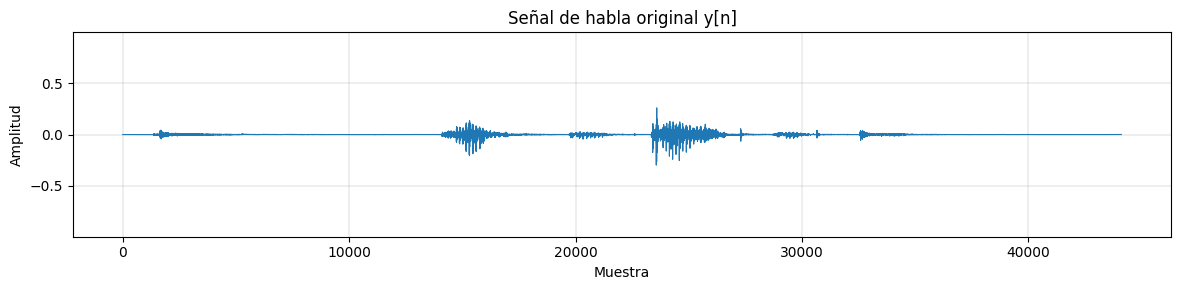

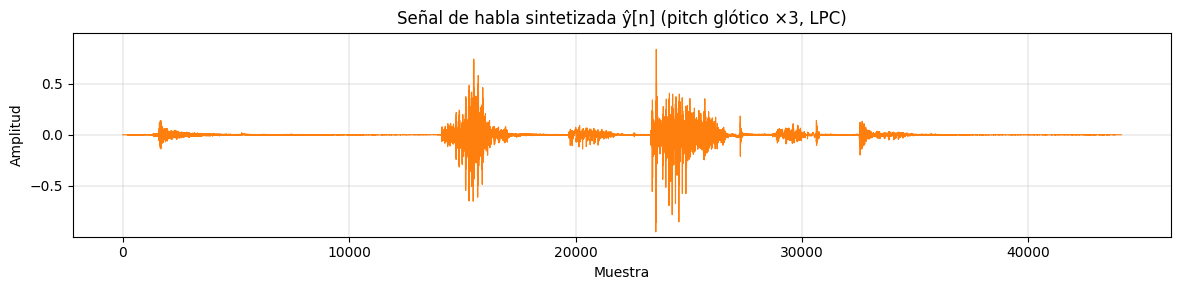

In [44]:
# ============================
# B) VOZ: dos gráficos separados
# ============================

ymax_voice = 1.05 * np.max(np.abs(np.concatenate([y, yhat_pitch])))

plt.figure(figsize=(12,3))
plt.plot(y, lw=0.8, color='C0')
plt.ylim(-ymax_voice, ymax_voice)
plt.title('Señal de habla original y[n]')
plt.xlabel('Muestra'); plt.ylabel('Amplitud')
plt.grid(True, linewidth=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,3))
plt.plot(yhat_pitch, lw=0.8, color='C1')
plt.ylim(-ymax_voice, ymax_voice)
plt.title('Señal de habla sintetizada ŷ[n] (pitch glótico ×3, LPC)')
plt.xlabel('Muestra'); plt.ylabel('Amplitud')
plt.grid(True, linewidth=0.3)
plt.tight_layout()
plt.show()

## Conclusiones finales — Ejercicio 15

Los resultados muestran diferencias **claramente perceptibles** entre la señal original y la señal modificada con el método `multiply_pitch_by_k_duplicate_decimate`.  

- En el análisis de la **ACF (Autocorrelación)** se observa un **desplazamiento de los picos** hacia lags menores, confirmando el aumento de la frecuencia glótica (pitch ×3).  
- La señal sintetizada presenta una **estructura temporal más densa**, evidenciando un cambio notorio respecto a la señal original.  
- En la comparación de las señales de habla, las diferencias de envolvente y periodicidad son visibles, validando que el método propuesto logra un **efecto de incremento real del pitch**.

En conclusión, la estrategia de duplicación implementada en `multiply_pitch_by_k_duplicate_decimate` permite modificar aún más la frecuencia glótica, generando un cambio más notorio y consistente en el timbre de la señal de voz.

## Conclusión Final  

A lo largo del trabajo se implementaron y analizaron técnicas de **modelado LPC**, **ventaneo** y **síntesis de voz**, explorando desde la estimación de pitch hasta la modificación de la frecuencia glótica. Los resultados mostraron cómo el enfoque de análisis-síntesis permite comprender y manipular la producción del habla, destacando la eficacia de los métodos LPC para representar y transformar señales de voz de manera controlada.  